# LIBRARY

In [1]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import date, datetime
from multiprocessing.spawn import import_main_path
from keras.preprocessing.sequence import TimeseriesGenerator
from pandas_datareader import data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np

from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D




# GET DATA

In [2]:
tickers = ["ANTM.JK","ASII.JK","ICBP.JK","JSMR.JK"]

today = date.today()
# print(today)
start_date = '2010-01-01'
end_date = '2022-08-02'

panel_data = data.DataReader(tickers,'yahoo',start_date,end_date)
panel_data.head(5)


Attributes    Adj Close                                               Close  \
Symbols         ANTM.JK      ASII.JK      ICBP.JK      JSMR.JK      ANTM.JK   
Date                                                                          
2010-01-04  1576.277222  2421.050781  1408.559082  1530.937866  1931.946777   
2010-01-05  1576.277222  2434.767578  1437.305054  1547.488403  1931.946777   
2010-01-06  1576.277222  2421.050781  1427.723022  1555.763916  1931.946777   
2010-01-07  1610.544067  2345.607422  1437.305054  1547.488403  1973.945557   
2010-01-08  1610.544067  2359.324463  1446.887207  1539.213257  1973.945557   

Attributes                                      High          ...     Low  \
Symbols    ASII.JK ICBP.JK      JSMR.JK      ANTM.JK ASII.JK  ... ICBP.JK   
Date                                                          ...           
2010-01-04  3530.0  1837.5  1845.677368  1931.946777  3550.0  ...  1762.5   
2010-01-05  3550.0  1875.0  1865.630737  1994.945068  3570.0  ...  1825.0   
2010-01-06  3530.0  1862.5  1875.607300  1994.945068  3580.0  ...  1862.5   
2010-01-07  3420.0  1875.0  1865.630737  1994.945068  3560.0  ...  1862.5   
2010-01-08  3440.0  1887.5  1855.654053  1994.945068  3450.0  ...  1862.5   

Attributes                      Open                                   Volume  \
Symbols         JSMR.JK      ANTM.JK ASII.JK ICBP.JK      JSMR.JK     ANTM.JK   
Date                                                                            
2010-01-04  1805.770874  1931.946777  3530.0  1787.5  1845.677368  39619544.0   
2010-01-05  1845.677368  1931.946777  3550.0  1875.0  1865.630737  62041590.0   
2010-01-06  1855.654053  1931.946777  3530.0  1900.0  1875.607300  30916328.0   
2010-01-07  1845.677368  1973.945557  3420.0  1875.0  1865.630737  30624653.0   
2010-01-08  1845.677368  1973.945557  3440.0  1900.0  1855.654053  15857579.0   

Attributes                                 
Symbols    ASII.JK     ICBP.JK    JSMR.JK  
Date                                       
2010-01-04    40.0  26442000.0  6978806.0  
2010-01-05    40.0  42874000.0  7988164.0  
2010-01-06    40.0  44946000.0  7538113.0  
2010-01-07    40.0  24863000.0  2048787.0  
2010-01-08    40.0  19118000.0  2441705.0  

[5 rows x 24 columns]

In [3]:
data_close = panel_data["Adj Close"]
data_close.head(5).round(2)
list(data_close)
data_close.columns = ['antm', 'asii', 'icbp', 'jsmr']
data_close

,antm,asii,icbp,jsmr
Date,,,,
2010-01-04,1576.277222,2421.050781,1408.559082,1530.937866
2010-01-05,1576.277222,2434.767578,1437.305054,1547.488403
2010-01-06,1576.277222,2421.050781,1427.723022,1555.763916
2010-01-07,1610.544067,2345.607422,1437.305054,1547.488403
2010-01-08,1610.544067,2359.324463,1446.887207,1539.213257
...,...,...,...,...
2022-07-27,1785.000000,6017.731934,9050.941406,3510.000000
2022-07-28,2000.000000,5968.406250,8758.188477,3580.000000
2022-07-29,1955.000000,6239.697266,8611.811523,3560.000000


# Normalize data

In [4]:
from sklearn.preprocessing import MinMaxScaler
def normalize_data(df_data, COLUMN_NAME):
    scaler = MinMaxScaler()
    df_data = pd.DataFrame(df_data)
    df_data = pd.DataFrame(scaler.fit_transform(df_data), columns = [COLUMN_NAME])
    return df_data


In [5]:
df_asii = normalize_data(data_close.asii,'asii')
df_icbp = normalize_data(data_close.icbp, 'icbp')
df_jsmr = normalize_data(data_close.jsmr, 'jsmr')

# SLIDING WINDOW FUNCTION

In [6]:
from numpy import array

def split_sequence(seq, n_steps):
    X,y = list(), list()
    for i in range(len(seq)):
        end_ix = i + n_steps
        if end_ix > len(seq)-1:
            break
        seq_x, seq_y =seq[i:end_ix],seq[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# RESET INDEX FUNCTION

In [7]:
from sklearn.model_selection import train_test_split
def reset_index_data(df_data):
    df_data = df_data.reset_index(drop=True)
    arr_df = df_data.to_numpy()
    flat_df = arr_df.flatten()
    return flat_df

# RESHAPE DATA FUNC

In [8]:
def reshape_data(X,N_FEATURES):
    X = X.reshape(X.shape[0],X.shape[1],N_FEATURES)
    return X

# TRAIN VANILA MODEL FUCTION

In [9]:
def train_lstm(X_train,y_train,config):
    #unpach config
    neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_vanila_lstm = Sequential([
    LSTM(neuron, activation=activation,input_shape=(n_steps, n_features)),
    Dense(1),
    ])
    model_vanila_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    model_vanila_lstm.summary()
    history_vanila_lstm = model_vanila_lstm.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          shuffle = True
    )

    return model_vanila_lstm, history_vanila_lstm

#time 41.8
    

In [10]:
def train_vanila_lstm(X_train,y_train,config):
    #unpach config
    neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_vanila_lstm = Sequential([
    LSTM(neuron, activation=activation,input_shape=(n_steps, n_features)),
    Dense(1),
    ])
    model_vanila_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_vanila_lstm.summary()
    history_vanila_lstm = model_vanila_lstm.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_vanila_lstm, history_vanila_lstm

#time 41.8
    

# ROUNDUP FUNCTION

In [11]:
def pembulatan(data,number):
    return np.round(data,number)

# MATRICS EVALUTE

In [12]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
def matriks_evaluate(preds,y_test, lb_saham, number):
    print('Matriks score for '+ lb_saham)
    print("mae score: "+str(mean_absolute_error(preds, y_test)))
    print("r2 score "+str(r2_score(preds, y_test)))
    print("mape score "+str(mean_absolute_percentage_error(preds, y_test)))
    print("rmse score "+str(np.sqrt(mean_squared_error(preds, y_test))))
    print("round_up")
    print("mae score: "+str(pembulatan(mean_absolute_error(preds, y_test),number)))
    print("r2 score "+str(pembulatan(r2_score(preds, y_test),number)))
    print("mape score "+str(pembulatan(mean_absolute_percentage_error(preds, y_test),number)))
    print("rmse score "+str(pembulatan(np.sqrt(mean_squared_error(preds, y_test)),number)))

# PLOT FUNCTION

In [13]:
def plot_metriks(data,title):
    names = list(data.keys())
    values = list(data.values())
    plt.title(title)
    plt.bar(range(len(data)), values, tick_label=names)
    plt.show()

# VANILA LSTM

## ANTM

In [14]:
#get data and normalize data
df_antm = normalize_data(data_close.antm,'antm')
#reset index
df_antm = reset_index_data(df_antm)
#data to supervised
antm_X, antm_y = split_sequence(df_antm, 2)
#split to train and test
X_train_antm, X_test_antm, y_train_antm, y_test_antm = train_test_split(antm_X, antm_y, test_size=0.33, random_state=42)

X_train_antm = reshape_data(X_train_antm,1)
X_test_antm = reshape_data(X_test_antm,1)


In [15]:
cfg_antm = [8,'relu',2,1,0.1,8,200]
model_antm,history_antm_model,  = train_vanila_lstm(X_train_antm,y_train_antm,cfg_antm)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 320       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
209/209 [==============================] - 4s 7ms/step - loss: 0.0448 - mae: 0.0448 - val_loss: 0.0299 - val_mae: 0.0299
Epoch 2/200
209/209 [==============================] - 1s 4ms/step - loss: 0.0261 - mae: 0.0261 - val_loss: 0.0342 - val_mae: 0.0342
Epoch 3/200
209/209 [==============================] - 1s 5ms/step - loss: 0.0233 - mae: 0.0233 - val_loss: 0.0161 - val_mae: 0.0161
Epoch 4/200
209/209 [==============================] - 

In [16]:
preds_antm = model_antm.predict(X_test_antm)
matriks_evaluate(preds_antm,y_test_antm,'antm',4)

33/33 [==============================] - 0s 2ms/step
Matriks score for antm
mae score: 0.008657112310047916
r2 score 0.9945017262756606
mape score 0.04446788611987502
rmse score 0.014420858182332697
round_up
mae score: 0.0087
r2 score 0.9945
mape score 0.0445
rmse score 0.0144


In [17]:
preds_antm_train = model_antm.predict(X_train_antm)
matriks_evaluate(preds_antm_train,y_train_antm,'antm',4)

66/66 [==============================] - 0s 2ms/step
Matriks score for antm
mae score: 0.008947362302805172
r2 score 0.9936887714258448
mape score 0.04802565873090378
rmse score 0.01545537910203571
round_up
mae score: 0.0089
r2 score 0.9937
mape score 0.048
rmse score 0.0155


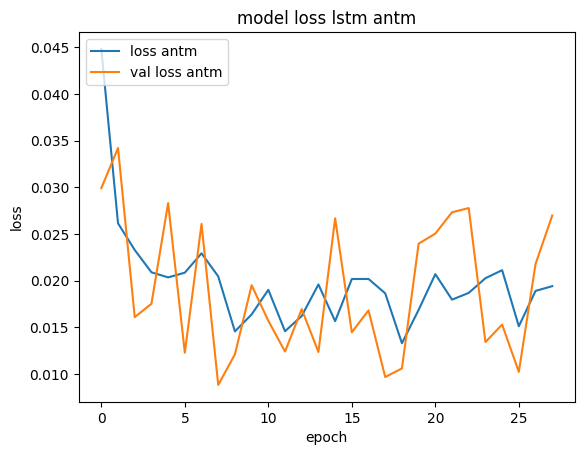

In [18]:
plt.plot(history_antm_model.history['loss'], label='loss antm')
plt.plot(history_antm_model.history['val_loss'], label = 'val loss antm')
plt.title('model loss lstm antm')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_antm', dpi=3600)

## ASII

In [19]:
#get data and normalize data
df_asii = normalize_data(data_close.asii,'asii')
#reset index
df_asii = reset_index_data(df_asii)
#data to supervised
asii_X, asii_y = split_sequence(df_asii, 3)
#split to train and test
X_train_asii, X_test_asii, y_train_asii, y_test_asii = train_test_split(asii_X, asii_y, test_size=0.33, random_state=42)

X_train_asii = reshape_data(X_train_asii,1)
X_test_asii = reshape_data(X_test_asii,1)


In [20]:
cfg_asii = [32,'relu',3,1,0.01,8,150]
model_asii,history_asii_model,  = train_vanila_lstm(X_train_asii,y_train_asii,cfg_asii)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4352      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
209/209 [==============================] - 4s 5ms/step - loss: 0.0459 - mae: 0.0459 - val_loss: 0.0217 - val_mae: 0.0217
Epoch 2/150
209/209 [==============================] - 1s 4ms/step - loss: 0.0246 - mae: 0.0246 - val_loss: 0.0181 - val_mae: 0.0181
Epoch 3/150
209/209 [==============================] - 1s 4ms/step - loss: 0.0236 - mae: 0.0236 - val_loss: 0.0169 - val_mae: 0.0169
Epoch 4/150
209/209 [============================

In [21]:
preds_asii = model_asii.predict(X_test_asii)
matriks_evaluate(preds_asii,y_test_asii,'asii',4)

33/33 [==============================] - 0s 3ms/step
Matriks score for asii
mae score: 0.015323180983502103
r2 score 0.9892378161615693
mape score 0.03461009747393943
rmse score 0.020467707506882357
round_up
mae score: 0.0153
r2 score 0.9892
mape score 0.0346
rmse score 0.0205


In [22]:
preds_asii_train = model_asii.predict(X_train_asii)
matriks_evaluate(preds_asii_train,y_train_asii,'asii',4)

66/66 [==============================] - 0s 2ms/step
Matriks score for asii
mae score: 0.015485768572581845
r2 score 0.989011476310363
mape score 0.03486395757637277
rmse score 0.02094414978952041
round_up
mae score: 0.0155
r2 score 0.989
mape score 0.0349
rmse score 0.0209


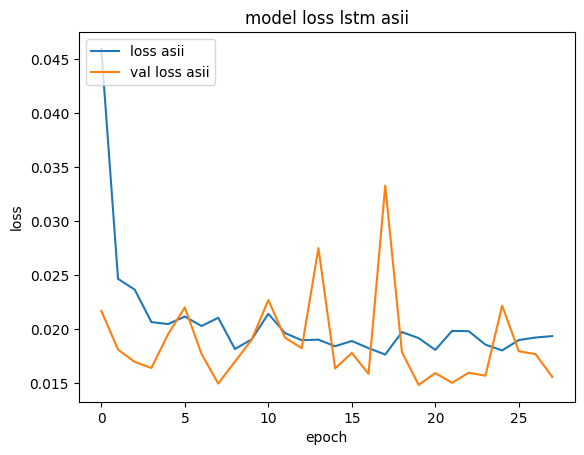

In [23]:
plt.plot(history_asii_model.history['loss'], label='loss asii')
plt.plot(history_asii_model.history['val_loss'], label = 'val loss asii')
plt.title('model loss lstm asii')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_asii', dpi=3600)

## ICBP


In [24]:
#get data and normalize data
df_icbp = normalize_data(data_close.icbp,'icbp')
#reset index
df_icbp = reset_index_data(df_icbp)
#data to supervised
icbp_X, icbp_y = split_sequence(df_icbp, 1)
#split to train and test
X_train_icbp, X_test_icbp, y_train_icbp, y_test_icbp = train_test_split(icbp_X, icbp_y, test_size=0.33, random_state=42)

X_train_icbp = reshape_data(X_train_icbp,1)
X_test_icbp = reshape_data(X_test_icbp,1)


In [25]:
# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_icbp = [8,'relu',1,1,0.01,16,200]
model_icbp,history_icbp_model,  = train_vanila_lstm(X_train_icbp,y_train_icbp,cfg_icbp)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 8)                 320       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
105/105 [==============================] - 6s 10ms/step - loss: 0.1498 - mae: 0.1498 - val_loss: 0.0217 - val_mae: 0.0217
Epoch 2/200
105/105 [==============================] - 0s 4ms/step - loss: 0.0220 - mae: 0.0220 - val_loss: 0.0243 - val_mae: 0.0243
Epoch 3/200
105/105 [==============================] - 0s 4ms/step - loss: 0.0166 - mae: 0.0166 - val_loss: 0.0122 - val_mae: 0.0122
Epoch 4/200
105/105 [==============================]

In [26]:
preds_icbp = model_icbp.predict(X_test_icbp)
matriks_evaluate(preds_icbp,y_test_icbp,'icbp',4)

33/33 [==============================] - 0s 2ms/step
Matriks score for icbp
mae score: 0.007275223957183907
r2 score 0.9983144184564314
mape score 0.029156484837131427
rmse score 0.011535376256092609
round_up
mae score: 0.0073
r2 score 0.9983
mape score 0.0292
rmse score 0.0115


In [27]:
preds_icbp_train = model_icbp.predict(X_train_icbp)
matriks_evaluate(preds_icbp_train,y_train_icbp,'icbp',4)

66/66 [==============================] - 0s 2ms/step
Matriks score for icbp
mae score: 0.007524722739054267
r2 score 0.9982430025851957
mape score 0.028281324240814188
rmse score 0.011329875531650963
round_up
mae score: 0.0075
r2 score 0.9982
mape score 0.0283
rmse score 0.0113


In [28]:
# Matriks score for icbp
pembulatan(0.007518278165003873
,2)
pembulatan(0.9980980760462315,2)
pembulatan(0.03298193863122954,2)
pembulatan(0.01215460388750067,2)

0.01

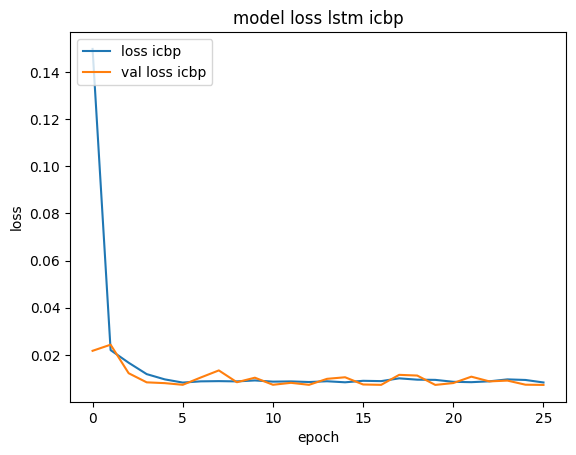

In [29]:
plt.plot(history_icbp_model.history['loss'], label='loss icbp')
plt.plot(history_icbp_model.history['val_loss'], label = 'val loss icbp')
plt.title('model loss lstm icbp')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_icbp', dpi=3600)

## JSMR

In [30]:
#get data and normalize data
df_jsmr = normalize_data(data_close.jsmr,'jsmr')
#reset index
df_jsmr = reset_index_data(df_jsmr)
#data to supervised
jsmr_X, jsmr_y = split_sequence(df_jsmr, 1)
#split to train and test
X_train_jsmr, X_test_jsmr, y_train_jsmr, y_test_jsmr = train_test_split(jsmr_X, jsmr_y, test_size=0.33, random_state=42)

X_train_jsmr = reshape_data(X_train_jsmr,1)
X_test_jsmr = reshape_data(X_test_jsmr,1)


In [31]:
# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_jsmr = [8,'relu',1,1,0.01,16,200]
model_jsmr,history_jsmr_model,  = train_vanila_lstm(X_train_jsmr,y_train_jsmr,cfg_jsmr)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 8)                 320       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
105/105 [==============================] - 5s 13ms/step - loss: 0.1364 - mae: 0.1364 - val_loss: 0.0242 - val_mae: 0.0242
Epoch 2/200
105/105 [==============================] - 1s 5ms/step - loss: 0.0221 - mae: 0.0221 - val_loss: 0.0185 - val_mae: 0.0185
Epoch 3/200
105/105 [==============================] - 0s 4ms/step - loss: 0.0202 - mae: 0.0202 - val_loss: 0.0202 - val_mae: 0.0202
Epoch 4/200
105/105 [==============================]

In [32]:
preds_jsmr = model_jsmr.predict(X_test_jsmr)
matriks_evaluate(preds_jsmr,y_test_jsmr,'jsmr',4)

33/33 [==============================] - 0s 2ms/step
Matriks score for jsmr
mae score: 0.011484133312639888
r2 score 0.9942310444155383
mape score 0.03340148058542159
rmse score 0.016153422165351695
round_up
mae score: 0.0115
r2 score 0.9942
mape score 0.0334
rmse score 0.0162


In [33]:
preds_jsmr_train = model_jsmr.predict(X_train_jsmr)
matriks_evaluate(preds_jsmr_train,y_train_jsmr,'jsmr',4)

66/66 [==============================] - 0s 3ms/step
Matriks score for jsmr
mae score: 0.012335035656699318
r2 score 0.9932938574744566
mape score 0.034691162976955986
rmse score 0.017314907024249652
round_up
mae score: 0.0123
r2 score 0.9933
mape score 0.0347
rmse score 0.0173


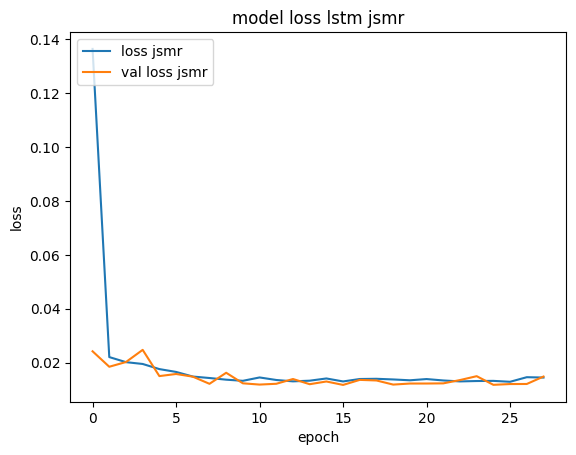

In [34]:
plt.plot(history_jsmr_model.history['loss'], label='loss jsmr')
plt.plot(history_jsmr_model.history['val_loss'], label = 'val loss jsmr')
plt.title('model loss lstm jsmr')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_jsmr', dpi=3600)

# BIDIRECTIONAL LSTM

In [35]:
def train_bidirectional_lstm(X_train,y_train,config):
    
    #unpach config
    neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_bidirectional_lstm = Sequential([
    Bidirectional(LSTM(neuron, activation=activation),input_shape=(n_steps, n_features)),
    Dense(1),
    ])
    model_bidirectional_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_bidirectional_lstm.summary()
    history_bidirectional_lstm = model_bidirectional_lstm.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_bidirectional_lstm, history_bidirectional_lstm

#time 41.8
    

## ANTM

In [36]:
cfg_antm = [8,'relu',2,1,0.1,8,200]
model_bidirectional_antm,history_antm_model_bidirectional,  = train_bidirectional_lstm(X_train_antm,y_train_antm,cfg_antm)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 16)               640       
 l)                                                              
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
209/209 [==============================] - 6s 8ms/step - loss: 0.0397 - mae: 0.0397 - val_loss: 0.0345 - val_mae: 0.0345
Epoch 2/200
209/209 [==============================] - 1s 4ms/step - loss: 0.0273 - mae: 0.0273 - val_loss: 0.0305 - val_mae: 0.0305
Epoch 3/200
209/209 [==============================] - 1s 4ms/step - loss: 0.0209 - mae: 0.0209 - val_loss: 0.0225 - val

In [37]:
preds_antm_bidirectional = model_bidirectional_antm.predict(X_test_antm)
matriks_evaluate(preds_antm_bidirectional,y_test_antm,'antm',4)

33/33 [==============================] - 1s 2ms/step
Matriks score for antm
mae score: 0.008622911295103711
r2 score 0.9947014825333139
mape score 0.03656672718775695
rmse score 0.01469868797014148
round_up
mae score: 0.0086
r2 score 0.9947
mape score 0.0366
rmse score 0.0147


In [38]:
preds_antm_bidirectional_train = model_bidirectional_antm.predict(X_train_antm)
matriks_evaluate(preds_antm_bidirectional_train,y_train_antm,'antm',4)

66/66 [==============================] - 0s 2ms/step
Matriks score for antm
mae score: 0.008286486078411792
r2 score 0.9951336483032924
mape score 0.03830854852373085
rmse score 0.014119775365046218
round_up
mae score: 0.0083
r2 score 0.9951
mape score 0.0383
rmse score 0.0141


In [39]:
# Matriks score for antm
# mae score: 0.008232755712539704
# r2 score 0.9956862906506637
# mape score 0.04528757310273332
# rmse score 0.013190786339141062

In [40]:
# Matriks score for icbp
pembulatan(0.008232755712539704
,4)
pembulatan(0.9956862906506637,4)
pembulatan(0.04528757310273332,4)
pembulatan(0.013190786339141062,4)

0.0132

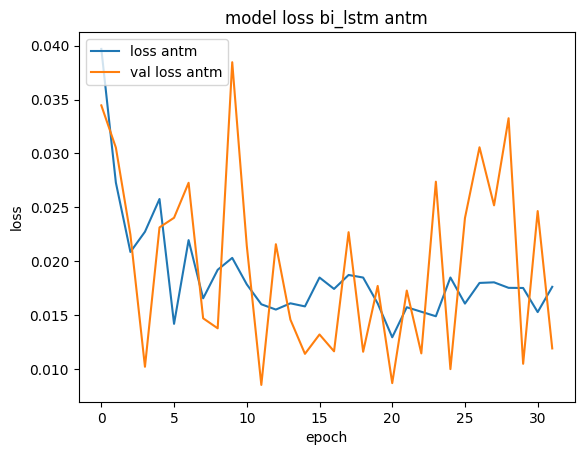

In [41]:
plt.plot(history_antm_model_bidirectional.history['loss'], label='loss antm')
plt.plot(history_antm_model_bidirectional.history['val_loss'], label = 'val loss antm')
plt.title('model loss bi_lstm antm')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_antm_bidirection', dpi=3600)

## ASII

In [42]:
cfg_asii = [32,'relu',3,1,0.01,8,150]
model_bidirectional_asii,history_asii_model_bidirectional,  = train_bidirectional_lstm(X_train_asii,y_train_asii,cfg_asii)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 64)               8704      
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
209/209 [==============================] - 5s 8ms/step - loss: 0.0439 - mae: 0.0439 - val_loss: 0.0238 - val_mae: 0.0238
Epoch 2/150
209/209 [==============================] - 1s 4ms/step - loss: 0.0224 - mae: 0.0224 - val_loss: 0.0226 - val_mae: 0.0226
Epoch 3/150
209/209 [==============================] - 1s 4ms/step - loss: 0.0244 - mae: 0.0244 - val_loss: 0.0171 -

In [43]:
preds_asii_bidirectional = model_bidirectional_asii.predict(X_test_asii)
matriks_evaluate(preds_asii_bidirectional,y_test_asii,'asii',4)

33/33 [==============================] - 1s 3ms/step
Matriks score for asii
mae score: 0.01479724933653656
r2 score 0.9901112920971714
mape score 0.03521634352555477
rmse score 0.01977363448841609
round_up
mae score: 0.0148
r2 score 0.9901
mape score 0.0352
rmse score 0.0198


In [44]:
preds_asii_bidirectional_train = model_bidirectional_asii.predict(X_train_asii)
matriks_evaluate(preds_asii_bidirectional_train,y_train_asii,'asii',4)

66/66 [==============================] - 0s 2ms/step
Matriks score for asii
mae score: 0.015132539036226996
r2 score 0.9896486158079891
mape score 0.03630860365165726
rmse score 0.020492867977016712
round_up
mae score: 0.0151
r2 score 0.9896
mape score 0.0363
rmse score 0.0205


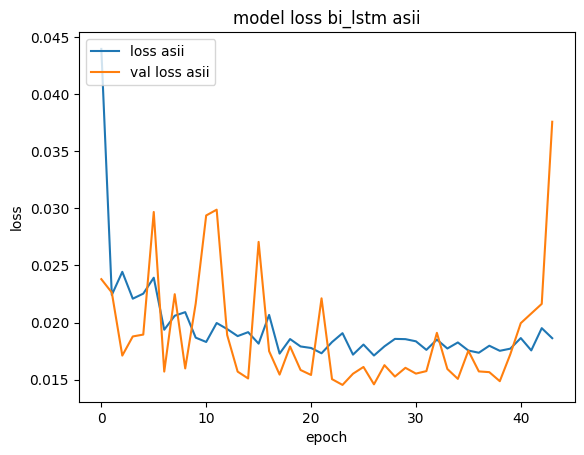

In [45]:
plt.plot(history_asii_model_bidirectional.history['loss'], label='loss asii')
plt.plot(history_asii_model_bidirectional.history['val_loss'], label = 'val loss asii')
plt.title('model loss bi_lstm asii')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_asii_bidirection', dpi=3600)

## ICBP

In [46]:
# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_icbp = [8,'relu',1,1,0.01,16,200]
model_bidirectional_icbp,history_icbp_model_bidirectional,  = train_bidirectional_lstm(X_train_icbp,y_train_icbp,cfg_icbp)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 16)               640       
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
105/105 [==============================] - 6s 12ms/step - loss: 0.1169 - mae: 0.1169 - val_loss: 0.0177 - val_mae: 0.0177
Epoch 2/200
105/105 [==============================] - 0s 4ms/step - loss: 0.0173 - mae: 0.0173 - val_loss: 0.0150 - val_mae: 0.0150
Epoch 3/200
105/105 [==============================] - 0s 4ms/step - loss: 0.0124 - mae: 0.0124 - val_loss: 0.0138 - va

In [48]:
preds_icbp_bidirectional = model_bidirectional_icbp.predict(X_test_icbp)
matriks_evaluate(preds_icbp_bidirectional,y_test_icbp,'icbp',4)

33/33 [==============================] - 1s 3ms/step
Matriks score for icbp
mae score: 0.0070742051141049304
r2 score 0.9983384075156176
mape score 0.027327299052445648
rmse score 0.011458474415415516
round_up
mae score: 0.0071
r2 score 0.9983
mape score 0.0273
rmse score 0.0115


In [135]:
preds_icbp_bidirectional_train = model_bidirectional_icbp.predict(X_train_icbp)
matriks_evaluate(preds_icbp_bidirectional_train,y_train_icbp,'icbp',4)

66/66 [==============================] - 1s 4ms/step
Matriks score for icbp
mae score: 0.007353016661614212
r2 score 0.9982722144423088
mape score 0.025281943891194467
rmse score 0.011239397998813279
round_up
mae score: 0.0074
r2 score 0.9983
mape score 0.0253
rmse score 0.0112


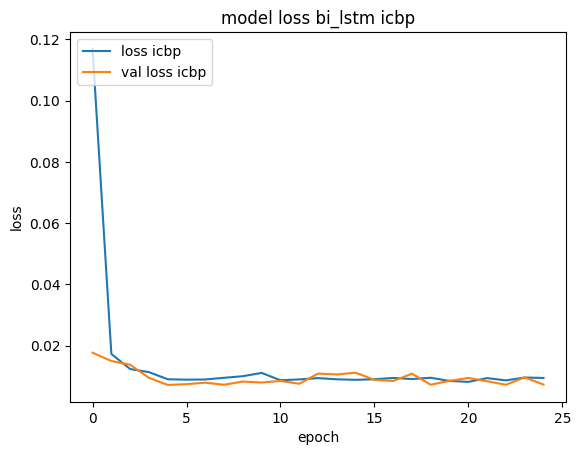

In [50]:
plt.plot(history_icbp_model_bidirectional.history['loss'], label='loss icbp')
plt.plot(history_icbp_model_bidirectional.history['val_loss'], label = 'val loss icbp')
plt.title('model loss bi_lstm icbp')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_icbp_bidirection', dpi=3600)

## JSMR

In [51]:
#get data and normalize data
df_jsmr = normalize_data(data_close.jsmr,'jsmr')
#reset index
df_jsmr = reset_index_data(df_jsmr)
#data to supervised
jsmr_X, jsmr_y = split_sequence(df_jsmr, 1)
#split to train and test
X_train_jsmr, X_test_jsmr, y_train_jsmr, y_test_jsmr = train_test_split(jsmr_X, jsmr_y, test_size=0.33, random_state=42)

X_train_jsmr = reshape_data(X_train_jsmr,1)
X_test_jsmr = reshape_data(X_test_jsmr,1)


# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_jsmr = [8,'relu',1,1,0.01,16,200]
model_bidirectional_jsmr,history_jsmr_model_bidirectional,  = train_bidirectional_lstm(X_train_jsmr,y_train_jsmr,cfg_jsmr)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 16)               640       
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
105/105 [==============================] - 7s 12ms/step - loss: 0.1839 - mae: 0.1839 - val_loss: 0.0670 - val_mae: 0.0670
Epoch 2/200
105/105 [==============================] - 1s 5ms/step - loss: 0.0336 - mae: 0.0336 - val_loss: 0.0269 - val_mae: 0.0269
Epoch 3/200
105/105 [==============================] - 0s 5ms/step - loss: 0.0235 - mae: 0.0235 - val_loss: 0.0229 - va

In [52]:
preds_jsmr_bidirectional = model_bidirectional_jsmr.predict(X_test_jsmr)
matriks_evaluate(preds_jsmr_bidirectional,y_test_jsmr,'jsmr',4)

33/33 [==============================] - 1s 3ms/step
Matriks score for jsmr
mae score: 0.011996797232113932
r2 score 0.9938727535462462
mape score 0.03820964529607501
rmse score 0.016613891938143832
round_up
mae score: 0.012
r2 score 0.9939
mape score 0.0382
rmse score 0.0166


In [53]:
preds_jsmr_bidirectional_train = model_bidirectional_jsmr.predict(X_train_jsmr)
matriks_evaluate(preds_jsmr_bidirectional_train,y_train_jsmr,'jsmr',4)

66/66 [==============================] - 0s 3ms/step
Matriks score for jsmr
mae score: 0.01285534165243304
r2 score 0.9928883554257484
mape score 0.03959436425262043
rmse score 0.017794802732621188
round_up
mae score: 0.0129
r2 score 0.9929
mape score 0.0396
rmse score 0.0178


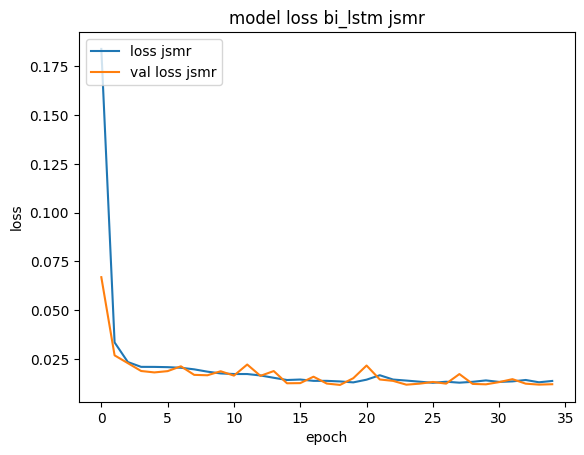

In [54]:
plt.plot(history_jsmr_model_bidirectional.history['loss'], label='loss jsmr')
plt.plot(history_jsmr_model_bidirectional.history['val_loss'], label = 'val loss jsmr')
plt.title('model loss bi_lstm jsmr')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_jsmr_bidirection', dpi=3600)

# CNN-LSTM

In [55]:
from keras.layers import Flatten 
from keras.layers import TimeDistributed 
from keras.layers.convolutional import Conv1D 
from keras.layers.convolutional import MaxPooling1D

In [56]:
def train_cnn_lstm(X_train,y_train,config):
    
    #unpach config
    neuron, activation, n_steps,n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_cnn_lstm = Sequential()
    model_cnn_lstm.add(TimeDistributed(Conv1D(64,1,activation=activation), input_shape=(None,n_steps,n_features)))
    model_cnn_lstm.add(TimeDistributed(MaxPooling1D()))
    model_cnn_lstm.add(TimeDistributed(Flatten()))
    model_cnn_lstm.add(LSTM(neuron, activation=activation))
    model_cnn_lstm.add(Dense(1))
    model_cnn_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_cnn_lstm.summary()
    history_cnn_lstm = model_cnn_lstm.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_cnn_lstm, history_cnn_lstm

#time 41.8
    

In [57]:
def reshape_data_cnn(X,N_FEATURES, N_SEQ, N_STEPS):
    X = X.reshape(X.shape[0],N_SEQ,N_STEPS,N_FEATURES)
    return X

## ANTM

In [58]:
#get data and normalize data
df_antm_cnn = normalize_data(data_close.antm,'antm')
#reset index
df_antm_cnn = reset_index_data(df_antm_cnn)
#data to supervised
antm_X_cnn, antm_y_cnn = split_sequence(df_antm_cnn, 2)
#split to train and test
X_train_antm_cnn, X_test_antm_cnn, y_train_antm_cnn, y_test_antm_cnn = train_test_split(antm_X_cnn, antm_y_cnn, test_size=0.33, random_state=44)

X_train_antm_cnn = reshape_data_cnn(X_train_antm_cnn,1,1,2)
X_test_antm_cnn = reshape_data_cnn(X_test_antm_cnn,1,1,2)

In [59]:
cfg_antm_cnn = [8,'relu',2,1,0.1,8,200]
model_cnn_antm,history_cnn_antm_model,  = train_cnn_lstm(X_train_antm_cnn,y_train_antm_cnn,cfg_antm_cnn)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 2, 64)      128       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 1, 64)      0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 64)         0         
 tributed)                                                       
                                                                 
 lstm_8 (LSTM)               (None, 8)                 2336      
                                                                 
 dense_8 (Dense)             (None, 1)                 9         
                                                      

In [60]:
preds_antm_cnn_lstm = model_cnn_antm.predict(X_test_antm_cnn)
matriks_evaluate(preds_antm_cnn_lstm,y_test_antm_cnn,'antm',4)

33/33 [==============================] - 0s 2ms/step
Matriks score for antm
mae score: 0.011021294974423265
r2 score 0.9916091934160977
mape score 0.06398360991337543
rmse score 0.018218946325348633
round_up
mae score: 0.011
r2 score 0.9916
mape score 0.064
rmse score 0.0182


In [61]:
preds_antm_cnn_lstm_train = model_cnn_antm.predict(X_train_antm_cnn)
matriks_evaluate(preds_antm_cnn_lstm_train,y_train_antm_cnn,'antm',4)

66/66 [==============================] - 0s 2ms/step
Matriks score for antm
mae score: 0.010472517158421018
r2 score 0.9923399788233194
mape score 0.05550699118534461
rmse score 0.01736426623622112
round_up
mae score: 0.0105
r2 score 0.9923
mape score 0.0555
rmse score 0.0174


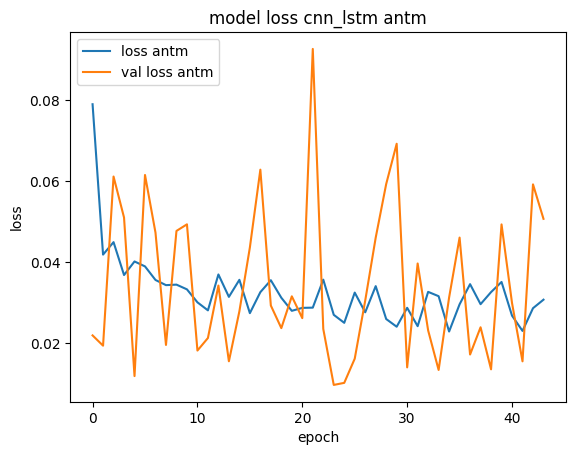

In [62]:
plt.plot(history_cnn_antm_model.history['loss'], label='loss antm')
plt.plot(history_cnn_antm_model.history['val_loss'], label = 'val loss antm')
plt.title('model loss cnn_lstm antm')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_antm_cnn', dpi=3600)

## ASII

In [63]:
#get data and normalize data
df_asii_cnn = normalize_data(data_close.asii,'asii')
#reset index
df_asii_cnn = reset_index_data(df_asii_cnn)
#data to supervised
asii_X_cnn, asii_y_cnn = split_sequence(df_asii_cnn, 3)
#split to train and test
X_train_asii_cnn, X_test_asii_cnn, y_train_asii_cnn, y_test_asii_cnn = train_test_split(asii_X_cnn, asii_y_cnn, test_size=0.33, random_state=44)

X_train_asii_cnn = reshape_data_cnn(X_train_asii_cnn,1,1,3)
X_test_asii_cnn = reshape_data_cnn(X_test_asii_cnn,1,1,3)

In [64]:
cfg_asii_cnn = [32,'relu',3,1,0.1,8,150]
model_cnn_asii,history_cnn_asii_model,  = train_cnn_lstm(X_train_asii_cnn,y_train_asii_cnn,cfg_asii_cnn)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, None, 3, 64)      128       
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, None, 1, 64)      0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, None, 64)         0         
 tributed)                                                       
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                      

In [65]:
preds_asii_cnn_lstm = model_cnn_asii.predict(X_test_asii_cnn)
matriks_evaluate(preds_asii_cnn_lstm,y_test_asii_cnn,'asii',4)

33/33 [==============================] - 0s 2ms/step
Matriks score for asii
mae score: 0.02423756730038611
r2 score 0.9728835319558249
mape score 0.05078264760323164
rmse score 0.031176198127129635
round_up
mae score: 0.0242
r2 score 0.9729
mape score 0.0508
rmse score 0.0312


In [66]:
preds_asii_cnn_lstm_train = model_cnn_asii.predict(X_train_asii_cnn)
matriks_evaluate(preds_asii_cnn_lstm_train,y_train_asii_cnn,'asii',4)

66/66 [==============================] - 0s 2ms/step
Matriks score for asii
mae score: 0.023983973400862613
r2 score 0.9743343044101298
mape score 0.057530487374470966
rmse score 0.031307511304486155
round_up
mae score: 0.024
r2 score 0.9743
mape score 0.0575
rmse score 0.0313


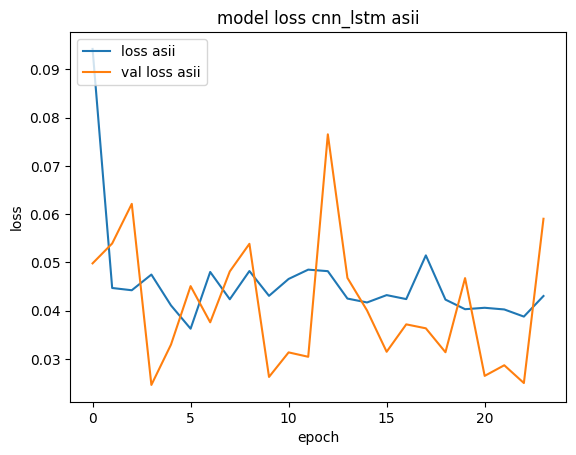

In [67]:
plt.plot(history_cnn_asii_model.history['loss'], label='loss asii')
plt.plot(history_cnn_asii_model.history['val_loss'], label = 'val loss asii')
plt.title('model loss cnn_lstm asii')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_asii_cnn', dpi=3600)

## ICBP

In [68]:
#get data and normalize data
df_icbp_cnn = normalize_data(data_close.icbp,'icbp')
#reset index
df_icbp_cnn = reset_index_data(df_icbp_cnn)
#data to supervised
icbp_X_cnn, icbp_y_cnn = split_sequence(df_icbp_cnn, 2)
#split to train and test
X_train_icbp_cnn, X_test_icbp_cnn, y_train_icbp_cnn, y_test_icbp_cnn = train_test_split(icbp_X_cnn, icbp_y_cnn, test_size=0.33, random_state=44)

X_train_icbp_cnn = reshape_data_cnn(X_train_icbp_cnn,1,1,2)
X_test_icbp_cnn = reshape_data_cnn(X_test_icbp_cnn,1,1,2)

In [69]:
cfg_icbp_cnn = [8,'relu',2,1,0.1,16,200]
model_cnn_icbp,history_cnn_icbp_model,  = train_cnn_lstm(X_train_icbp_cnn,y_train_icbp_cnn,cfg_icbp_cnn)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, None, 2, 64)      128       
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, None, 1, 64)      0         
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, None, 64)         0         
 tributed)                                                       
                                                                 
 lstm_10 (LSTM)              (None, 8)                 2336      
                                                                 
 dense_10 (Dense)            (None, 1)                 9         
                                                     

In [70]:
preds_icbp_cnn_lstm = model_cnn_icbp.predict(X_test_icbp_cnn)
matriks_evaluate(preds_icbp_cnn_lstm,y_test_icbp_cnn,'icbp',4)

33/33 [==============================] - 1s 2ms/step
Matriks score for icbp
mae score: 0.010949309996474109
r2 score 0.996544577747418
mape score 0.05647788015730526
rmse score 0.015812476177474177
round_up
mae score: 0.0109
r2 score 0.9965
mape score 0.0565
rmse score 0.0158


In [71]:
preds_icbp_cnn_lstm_train = model_cnn_icbp.predict(X_train_icbp_cnn)
matriks_evaluate(preds_icbp_cnn_lstm_train,y_train_icbp_cnn,'icbp',4)

66/66 [==============================] - 0s 2ms/step
Matriks score for icbp
mae score: 0.010383101510585201
r2 score 0.9972643054239857
mape score 0.06243162635517396
rmse score 0.014366541317036553
round_up
mae score: 0.0104
r2 score 0.9973
mape score 0.0624
rmse score 0.0144


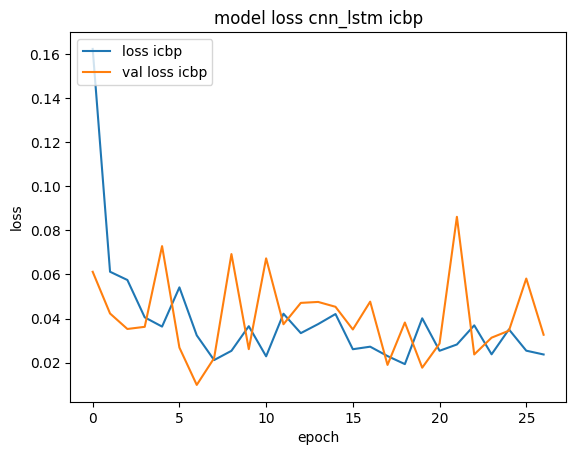

In [72]:
plt.plot(history_cnn_icbp_model.history['loss'], label='loss icbp')
plt.plot(history_cnn_icbp_model.history['val_loss'], label = 'val loss icbp')
plt.title('model loss cnn_lstm icbp')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_icbp_cnn', dpi=3600)

## JSMR

In [73]:
#get data and normalize data
df_jsmr_cnn = normalize_data(data_close.jsmr,'jsmr')
#reset index
df_jsmr_cnn = reset_index_data(df_jsmr_cnn)
#data to supervised
jsmr_X_cnn, jsmr_y_cnn = split_sequence(df_jsmr_cnn, 4)
#split to train and test
X_train_jsmr_cnn, X_test_jsmr_cnn, y_train_jsmr_cnn, y_test_jsmr_cnn = train_test_split(jsmr_X_cnn, jsmr_y_cnn, test_size=0.33, random_state=44)

X_train_jsmr_cnn = reshape_data_cnn(X_train_jsmr_cnn,1,2,2)
X_test_jsmr_cnn = reshape_data_cnn(X_test_jsmr_cnn,1,2,2)

In [74]:
cfg_jsmr_cnn = [8,'relu',2,1,0.1,16,200]
model_cnn_jsmr,history_cnn_jsmr_model,  = train_cnn_lstm(X_train_jsmr_cnn,y_train_jsmr_cnn,cfg_jsmr_cnn)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDis  (None, None, 2, 64)      128       
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, None, 1, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, None, 64)         0         
 stributed)                                                      
                                                                 
 lstm_11 (LSTM)              (None, 8)                 2336      
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                     

In [75]:
preds_jsmr_cnn_lstm = model_cnn_jsmr.predict(X_test_jsmr_cnn)
matriks_evaluate(preds_jsmr_cnn_lstm,y_test_jsmr_cnn,'jsmr',4)

33/33 [==============================] - 1s 5ms/step
Matriks score for jsmr
mae score: 0.16531996334939422
r2 score -12442408144680.607
mape score 0.2690747174971619
rmse score 0.21024821904793656
round_up
mae score: 0.1653
r2 score -12442408144680.607
mape score 0.2691
rmse score 0.2102


In [76]:
preds_jsmr_cnn_lstm_train = model_cnn_jsmr.predict(X_train_jsmr_cnn)
matriks_evaluate(preds_jsmr_cnn_lstm_train,y_train_jsmr_cnn,'jsmr',4)

66/66 [==============================] - 0s 3ms/step
Matriks score for jsmr
mae score: 0.16874503362241314
r2 score 0.0
mape score 0.27464936073714824
rmse score 0.21731142452364438
round_up
mae score: 0.1687
r2 score 0.0
mape score 0.2746
rmse score 0.2173


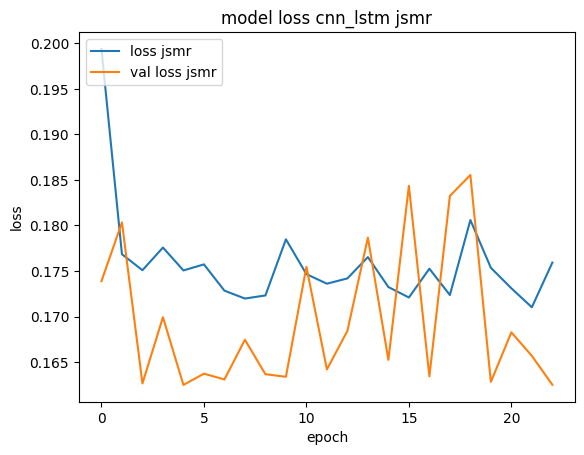

In [77]:
plt.plot(history_cnn_jsmr_model.history['loss'], label='loss jsmr')
plt.plot(history_cnn_jsmr_model.history['val_loss'], label = 'val loss jsmr')
plt.title('model loss cnn_lstm jsmr')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_jsmr_cnn', dpi=3600)

# CONVLSTM

In [78]:
def train_conv_lstm(X_train,y_train,config):
    
    #unpach config
    neuron, activation, n_steps,n_seq,n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_conv_lstm = Sequential()
    model_conv_lstm.add(ConvLSTM2D(neuron,(1,2),activation=activation, input_shape=(n_seq,1,n_steps,n_features)))
    model_conv_lstm.add(Flatten())
    model_conv_lstm.add(Dense(1))
    model_conv_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_conv_lstm.summary()
    history_conv_lstm = model_conv_lstm.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_conv_lstm, history_conv_lstm

#time 41.8
    

In [79]:
def reshape_data_conv(X,N_FEATURES, N_SEQ,N_ROWS, N_STEPS):
    X = X.reshape(X.shape[0],N_SEQ,N_ROWS,N_STEPS,N_FEATURES)
    return X

## ANTM

In [80]:
#get data and normalize data
df_antm_conv = normalize_data(data_close.antm,'antm')
#reset index
df_antm_conv = reset_index_data(df_antm_conv)
#data to supervised
antm_X_conv, antm_y_conv = split_sequence(df_antm_conv, 2)
#split to train and test
X_train_antm_conv, X_test_antm_conv, y_train_antm_conv, y_test_antm_conv = train_test_split(antm_X_conv, antm_y_conv, test_size=0.33, random_state=42)

X_train_antm_conv = reshape_data_conv(X_train_antm_conv,1,1,1,2)
X_test_antm_conv = reshape_data_conv(X_test_antm_conv,1,1,1,2)

In [81]:
cfg_antm_conv = [8,'relu',2,1,1,0.1,8,200]
model_conv_antm,history_conv_antm_model,  = train_conv_lstm(X_train_antm_conv,y_train_antm_conv,cfg_antm_conv)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 1, 8)           608       
                                                                 
 flatten_4 (Flatten)         (None, 8)                 0         
                                                                 
 dense_12 (Dense)            (None, 1)                 9         
                                                                 
Total params: 617
Trainable params: 617
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
209/209 [==============================] - 8s 8ms/step - loss: 0.0384 - mae: 0.0384 - val_loss: 0.0322 - val_mae: 0.0322
Epoch 2/200
209/209 [==============================] - 1s 5ms/step - loss: 0.0273 - mae: 0.0273 - val_loss: 0.0335 - val_mae: 0.0335
Epoch 3/200
209/209 [==============================] 

In [82]:
preds_antm_conv_lstm = model_conv_antm.predict(X_test_antm_conv)
matriks_evaluate(preds_antm_conv_lstm,y_test_antm_conv,'antm',4)

33/33 [==============================] - 1s 3ms/step
Matriks score for antm
mae score: 0.00949778272261078
r2 score 0.9937580542432792
mape score 0.04760711790058863
rmse score 0.015957795428146876
round_up
mae score: 0.0095
r2 score 0.9938
mape score 0.0476
rmse score 0.016


In [83]:
preds_antm_conv_lstm_train = model_conv_antm.predict(X_train_antm_conv)
matriks_evaluate(preds_antm_conv_lstm_train,y_train_antm_conv,'antm',4)

66/66 [==============================] - 0s 3ms/step
Matriks score for antm
mae score: 0.008992246730890633
r2 score 0.9947001696917529
mape score 0.04976029295887214
rmse score 0.014753566562871436
round_up
mae score: 0.009
r2 score 0.9947
mape score 0.0498
rmse score 0.0148


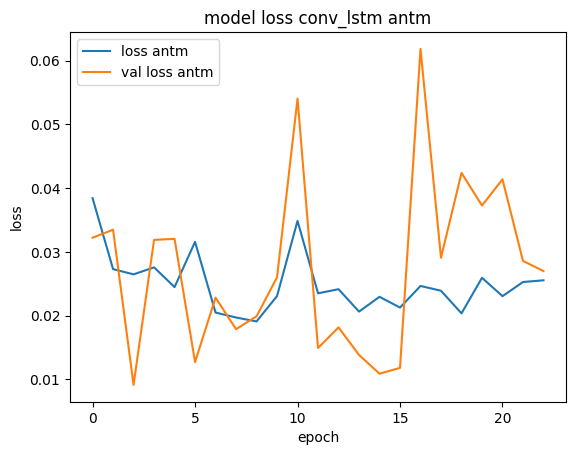

In [84]:
plt.plot(history_conv_antm_model.history['loss'], label='loss antm')
plt.plot(history_conv_antm_model.history['val_loss'], label = 'val loss antm')
plt.title('model loss conv_lstm antm')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_antm_conv', dpi=3600)

## ASII

In [85]:
#get data and normalize data
df_asii_conv = normalize_data(data_close.asii,'asii')
#reset index
df_asii_conv = reset_index_data(df_asii_conv)
#data to supervised
asii_X_conv, asii_y_conv = split_sequence(df_asii_conv, 3)
#split to train and test
X_train_asii_conv, X_test_asii_conv, y_train_asii_conv, y_test_asii_conv = train_test_split(asii_X_conv, asii_y_conv, test_size=0.33, random_state=42)

X_train_asii_conv = reshape_data_conv(X_train_asii_conv,1,1,1,3)
X_test_asii_conv = reshape_data_conv(X_test_asii_conv,1,1,1,3)

In [86]:
cfg_asii_conv = [32,'relu',3,1,1,0.1,8,150]
model_conv_asii,history_conv_asii_model,  = train_conv_lstm(X_train_asii_conv,y_train_asii_conv,cfg_asii_conv)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_1 (ConvLSTM2D)  (None, 1, 2, 32)          8576      
                                                                 
 flatten_5 (Flatten)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 8,641
Trainable params: 8,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
209/209 [==============================] - 5s 6ms/step - loss: 0.0717 - mae: 0.0717 - val_loss: 0.0295 - val_mae: 0.0295
Epoch 2/150
209/209 [==============================] - 1s 3ms/step - loss: 0.0356 - mae: 0.0356 - val_loss: 0.0330 - val_mae: 0.0330
Epoch 3/150
209/209 [============================

In [87]:
preds_asii_conv_lstm = model_conv_asii.predict(X_test_asii_conv)
matriks_evaluate(preds_asii_conv_lstm,y_test_asii_conv,'asii',4)

33/33 [==============================] - 0s 2ms/step
Matriks score for asii
mae score: 0.016263541889847844
r2 score 0.9889259073934511
mape score 0.03836870901920359
rmse score 0.02116134361584676
round_up
mae score: 0.0163
r2 score 0.9889
mape score 0.0384
rmse score 0.0212


In [88]:
preds_asii_conv_lstm_train = model_conv_asii.predict(X_train_asii_conv)
matriks_evaluate(preds_asii_conv_lstm_train,y_train_asii_conv,'asii',4)

66/66 [==============================] - 0s 2ms/step
Matriks score for asii
mae score: 0.016466873868986005
r2 score 0.9886168449179454
mape score 0.06789215777776147
rmse score 0.021822996001890478
round_up
mae score: 0.0165
r2 score 0.9886
mape score 0.0679
rmse score 0.0218


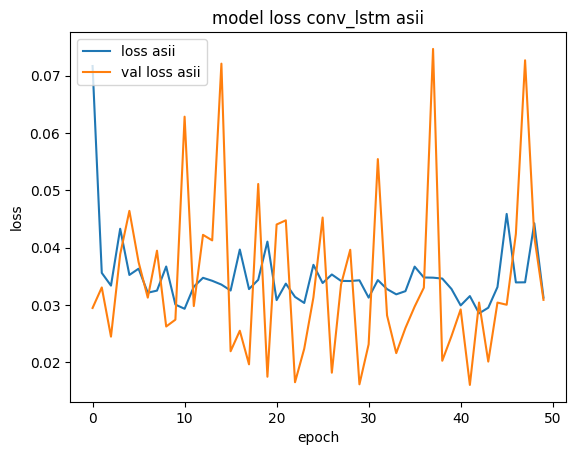

In [89]:
plt.plot(history_conv_asii_model.history['loss'], label='loss asii')
plt.plot(history_conv_asii_model.history['val_loss'], label = 'val loss asii')
plt.title('model loss conv_lstm asii')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_asii_conv', dpi=3600)

## ICBP

In [90]:
#get data and normalize data
df_icbp_conv = normalize_data(data_close.icbp,'icbp')
#reset index
df_icbp_conv = reset_index_data(df_icbp_conv)
#data to supervised
icbp_X_conv, icbp_y_conv = split_sequence(df_icbp_conv, 2)
#split to train and test
X_train_icbp_conv, X_test_icbp_conv, y_train_icbp_conv, y_test_icbp_conv = train_test_split(icbp_X_conv, icbp_y_conv, test_size=0.33, random_state=42)

X_train_icbp_conv = reshape_data_conv(X_train_icbp_conv,1,1,1,2)
X_test_icbp_conv = reshape_data_conv(X_test_icbp_conv,1,1,1,2)

In [91]:
cfg_icbp_conv = [8,'relu',2,1,1,0.1,16,200]
model_conv_icbp,history_conv_icbp_model,  = train_conv_lstm(X_train_icbp_conv,y_train_icbp_conv,cfg_icbp_conv)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_2 (ConvLSTM2D)  (None, 1, 1, 8)           608       
                                                                 
 flatten_6 (Flatten)         (None, 8)                 0         
                                                                 
 dense_14 (Dense)            (None, 1)                 9         
                                                                 
Total params: 617
Trainable params: 617
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
105/105 [==============================] - 7s 7ms/step - loss: 0.0699 - mae: 0.0699 - val_loss: 0.0356 - val_mae: 0.0356
Epoch 2/200
105/105 [==============================] - 0s 4ms/step - loss: 0.0305 - mae: 0.0305 - val_loss: 0.0142 - val_mae: 0.0142
Epoch 3/200
105/105 [==============================] 

In [92]:
preds_icbp_conv_lstm = model_conv_icbp.predict(X_test_icbp_conv)
matriks_evaluate(preds_icbp_conv_lstm,y_test_icbp_conv,'icbp',4)

33/33 [==============================] - 0s 2ms/step
Matriks score for icbp
mae score: 0.008497420304435102
r2 score 0.9982065739876593
mape score 0.04495359135701589
rmse score 0.011731494684021796
round_up
mae score: 0.0085
r2 score 0.9982
mape score 0.045
rmse score 0.0117


In [93]:
preds_icbp_conv_lstm_train = model_conv_icbp.predict(X_train_icbp_conv)
matriks_evaluate(preds_icbp_conv_lstm_train,y_train_icbp_conv,'icbp',4)

66/66 [==============================] - 0s 2ms/step
Matriks score for icbp
mae score: 0.008976578149205012
r2 score 0.9976669322032182
mape score 0.04503135869728088
rmse score 0.012865764919506301
round_up
mae score: 0.009
r2 score 0.9977
mape score 0.045
rmse score 0.0129


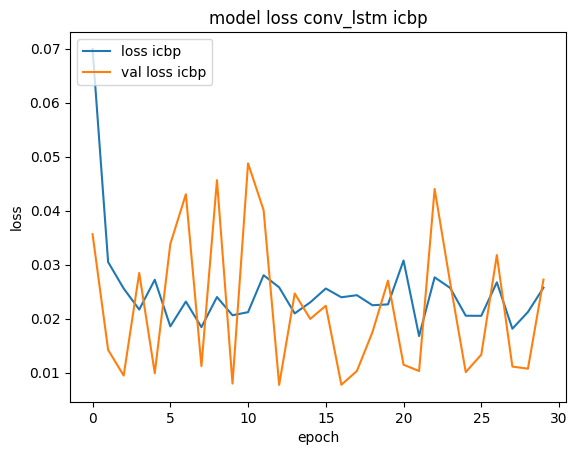

In [94]:
plt.plot(history_conv_icbp_model.history['loss'], label='loss icbp')
plt.plot(history_conv_icbp_model.history['val_loss'], label = 'val loss icbp')
plt.title('model loss conv_lstm icbp')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_icbp_conv', dpi=3600)

## JSMR

In [95]:
#get data and normalize data
df_jsmr_conv = normalize_data(data_close.jsmr,'jsmr')
#reset index
df_jsmr_conv = reset_index_data(df_jsmr_conv)
#data to supervised
jsmr_X_conv, jsmr_y_conv = split_sequence(df_jsmr_conv, 4)
#split to train and test
X_train_jsmr_conv, X_test_jsmr_conv, y_train_jsmr_conv, y_test_jsmr_conv = train_test_split(jsmr_X_conv, jsmr_y_conv, test_size=0.33, random_state=42)

X_train_jsmr_conv = reshape_data_conv(X_train_jsmr_conv,1,1,1,4)
X_test_jsmr_conv = reshape_data_conv(X_test_jsmr_conv,1,1,1,4)

In [96]:
cfg_jsmr_conv = [8,'relu',4,1,1,0.1,16,200]
model_conv_jsmr,history_conv_jsmr_model  = train_conv_lstm(X_train_jsmr_conv,y_train_jsmr_conv,cfg_jsmr_conv)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_3 (ConvLSTM2D)  (None, 1, 3, 8)           608       
                                                                 
 flatten_7 (Flatten)         (None, 24)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 25        
                                                                 
Total params: 633
Trainable params: 633
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
105/105 [==============================] - 5s 9ms/step - loss: 0.0796 - mae: 0.0796 - val_loss: 0.0249 - val_mae: 0.0249
Epoch 2/200
105/105 [==============================] - 0s 4ms/step - loss: 0.0360 - mae: 0.0360 - val_loss: 0.0492 - val_mae: 0.0492
Epoch 3/200
105/105 [==============================] 

In [97]:
preds_jsmr_conv_lstm = model_conv_jsmr.predict(X_test_jsmr_conv)
matriks_evaluate(preds_jsmr_conv_lstm,y_test_jsmr_conv,'jsmr',4)

33/33 [==============================] - 0s 2ms/step
Matriks score for jsmr
mae score: 0.01329576143059565
r2 score 0.9929105246983817
mape score 0.045080750162644526
rmse score 0.018060940566356463
round_up
mae score: 0.0133
r2 score 0.9929
mape score 0.0451
rmse score 0.0181


In [98]:
preds_jsmr_conv_lstm_train = model_conv_jsmr.predict(X_train_jsmr_conv)
matriks_evaluate(preds_jsmr_conv_lstm_train,y_train_jsmr_conv,'jsmr',4)

66/66 [==============================] - 0s 2ms/step
Matriks score for jsmr
mae score: 0.013912468455334955
r2 score 0.9919904113965776
mape score 0.04335395570674651
rmse score 0.019017986810129714
round_up
mae score: 0.0139
r2 score 0.992
mape score 0.0434
rmse score 0.019


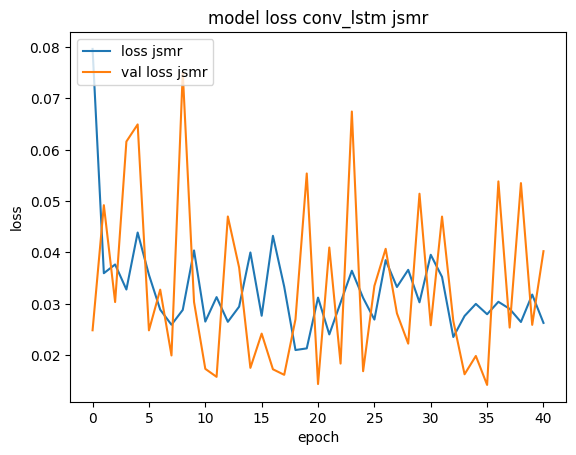

In [99]:
plt.plot(history_conv_jsmr_model.history['loss'], label='loss jsmr')
plt.plot(history_conv_jsmr_model.history['val_loss'], label = 'val loss jsmr')
plt.title('model loss conv_lstm jsmr')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_jsmr_conv', dpi=3600)

# RNN

In [100]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

def train_rnn(X_train,y_train,config):
    
    #unpach config
    neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_rnn = Sequential([
    SimpleRNN(neuron, activation=activation,input_shape=(n_steps, n_features)),
    Dense(1),
    ])
    model_rnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_rnn.summary()
    history_model_rnn = model_rnn.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_rnn, history_model_rnn

#time 41.8
    

## ANTM

In [101]:
#get data and normalize data
df_antm_rnn = normalize_data(data_close.antm,'antm')
#reset index
df_antm_rnn = reset_index_data(df_antm_rnn)
#data to supervised
antm_X_rnn, antm_y_rnn = split_sequence(df_antm_rnn, 2)
#split to train and test
X_train_antm_rnn, X_test_antm_rnn, y_train_antm_rnn, y_test_antm_rnn = train_test_split(antm_X_rnn, antm_y_rnn, test_size=0.33, random_state=42)

X_train_antm_rnn = reshape_data(X_train_antm_rnn,1)
X_test_antm_rnn = reshape_data(X_test_antm_rnn,1)


In [102]:
cfg_antm_rnn = [8,'relu',2,1,0.1,8,200]
model_antm_rnn,history_antm_model_rnn,  = train_rnn(X_train_antm_rnn,y_train_antm_rnn,cfg_antm_rnn)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 80        
                                                                 
 dense_16 (Dense)            (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
209/209 [==============================] - 2s 5ms/step - loss: 0.0337 - mae: 0.0337 - val_loss: 0.0223 - val_mae: 0.0223
Epoch 2/200
209/209 [==============================] - 1s 3ms/step - loss: 0.0246 - mae: 0.0246 - val_loss: 0.0571 - val_mae: 0.0571
Epoch 3/200
209/209 [==============================] - 1s 3ms/step - loss: 0.0272 - mae: 0.0272 - val_loss: 0.0155 - val_mae: 0.0155
Epoch 4/200
209/209 [==============================] -

In [103]:
preds_antm_rnn = model_antm_rnn.predict(X_test_antm_rnn)
matriks_evaluate(preds_antm_rnn,y_test_antm_rnn,'antm',4)

33/33 [==============================] - 0s 1ms/step
Matriks score for antm
mae score: 0.008927611071349425
r2 score 0.9945063699055186
mape score 0.04569448885579951
rmse score 0.014787619330829591
round_up
mae score: 0.0089
r2 score 0.9945
mape score 0.0457
rmse score 0.0148


In [104]:
preds_antm_rnn_train = model_antm_rnn.predict(X_train_antm_rnn)
matriks_evaluate(preds_antm_rnn_train,y_train_antm_rnn,'antm',4)

66/66 [==============================] - 0s 1ms/step
Matriks score for antm
mae score: 0.008877075173964634
r2 score 0.9945001917712863
mape score 0.04879890595621316
rmse score 0.01480756663955599
round_up
mae score: 0.0089
r2 score 0.9945
mape score 0.0488
rmse score 0.0148


In [105]:
# Matriks score for antm
pembulatan(0.010741172328190532,2)
pembulatan(0.9918942103762897,2)
pembulatan(0.060096347557924944,2)
pembulatan(0.018061080505563522,2)

0.02

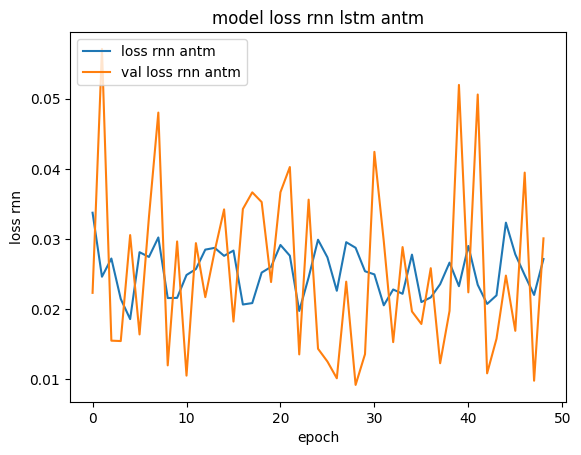

In [106]:
plt.plot(history_antm_model_rnn.history['loss'], label='loss rnn antm')
plt.plot(history_antm_model_rnn.history['val_loss'], label = 'val loss rnn antm')
plt.title('model loss rnn lstm antm')
plt.ylabel('loss rnn')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss rnn_antm', dpi=3600)

## ASII

In [107]:
#get data and normalize data
df_asii_rnn = normalize_data(data_close.asii,'asii')
#reset index
df_asii_rnn = reset_index_data(df_asii_rnn)
#data to supervised
asii_X_rnn, asii_y_rnn = split_sequence(df_asii_rnn, 3)
#split to train and test
X_train_asii_rnn, X_test_asii_rnn, y_train_asii_rnn, y_test_asii_rnn = train_test_split(asii_X_rnn, asii_y_rnn, test_size=0.33, random_state=42)

X_train_asii_rnn = reshape_data(X_train_asii_rnn,1)
X_test_asii_rnn = reshape_data(X_test_asii_rnn,1)


In [108]:
cfg_asii_rnn = [32,'relu',3,1,0.01,8,150]
model_asii_rnn,history_asii_model_rnn  = train_rnn(X_train_asii_rnn,y_train_asii_rnn,cfg_asii_rnn)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 32)                1088      
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
209/209 [==============================] - 3s 5ms/step - loss: 0.0347 - mae: 0.0347 - val_loss: 0.0250 - val_mae: 0.0250
Epoch 2/150
209/209 [==============================] - 1s 3ms/step - loss: 0.0243 - mae: 0.0243 - val_loss: 0.0172 - val_mae: 0.0172
Epoch 3/150
209/209 [==============================] - 1s 3ms/step - loss: 0.0194 - mae: 0.0194 - val_loss: 0.0217 - val_mae: 0.0217
Epoch 4/150
209/209 [===========================

In [109]:
preds_asii_rnn = model_asii_rnn.predict(X_test_asii_rnn)
matriks_evaluate(preds_asii_rnn,y_test_asii_rnn,'asii',4)

33/33 [==============================] - 1s 3ms/step
Matriks score for asii
mae score: 0.015614504035103564
r2 score 0.9893942641580827
mape score 0.034738871334966386
rmse score 0.020679588431639202
round_up
mae score: 0.0156
r2 score 0.9894
mape score 0.0347
rmse score 0.0207


In [110]:
preds_asii_rnn_train = model_asii_rnn.predict(X_train_asii_rnn)
matriks_evaluate(preds_asii_rnn_train,y_train_asii_rnn,'asii',4)

66/66 [==============================] - 0s 2ms/step
Matriks score for asii
mae score: 0.015647704549062173
r2 score 0.9893495951967987
mape score 0.034256382232532294
rmse score 0.02099779892291243
round_up
mae score: 0.0156
r2 score 0.9893
mape score 0.0343
rmse score 0.021


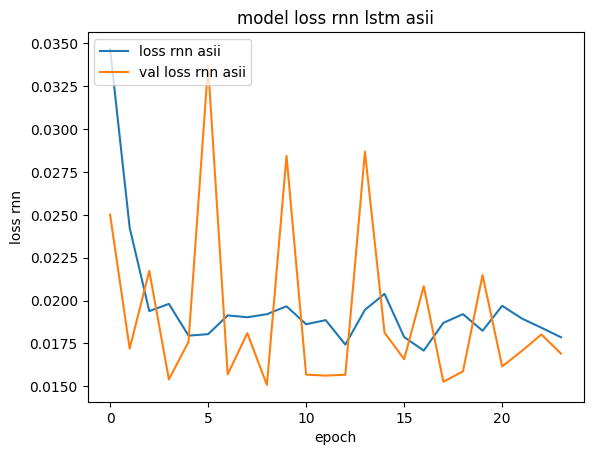

In [111]:
plt.plot(history_asii_model_rnn.history['loss'], label='loss rnn asii')
plt.plot(history_asii_model_rnn.history['val_loss'], label = 'val loss rnn asii')
plt.title('model loss rnn lstm asii')
plt.ylabel('loss rnn')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss rnn_asii', dpi=3600)

## ICBP

In [112]:
#get data and normalize data
df_icbp_rnn = normalize_data(data_close.icbp,'icbp')
#reset index
df_icbp_rnn = reset_index_data(df_icbp_rnn)
#data to supervised
icbp_X_rnn, icbp_y_rnn = split_sequence(df_icbp_rnn, 1)
#split to train and test
X_train_icbp_rnn, X_test_icbp_rnn, y_train_icbp_rnn, y_test_icbp_rnn = train_test_split(icbp_X_rnn, icbp_y_rnn, test_size=0.33, random_state=42)

X_train_icbp_rnn = reshape_data(X_train_icbp_rnn,1)
X_test_icbp_rnn = reshape_data(X_test_icbp_rnn,1)


In [113]:
cfg_icbp_rnn = [8,'relu',1,1,0.01,16,200]
model_icbp_rnn,history_icbp_model_rnn  = train_rnn(X_train_icbp_rnn,y_train_icbp_rnn,cfg_icbp_rnn)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 8)                 80        
                                                                 
 dense_18 (Dense)            (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
105/105 [==============================] - 2s 8ms/step - loss: 0.0883 - mae: 0.0883 - val_loss: 0.0087 - val_mae: 0.0087
Epoch 2/200
105/105 [==============================] - 0s 4ms/step - loss: 0.0095 - mae: 0.0095 - val_loss: 0.0080 - val_mae: 0.0080
Epoch 3/200
105/105 [==============================] - 0s 4ms/step - loss: 0.0089 - mae: 0.0089 - val_loss: 0.0082 - val_mae: 0.0082
Epoch 4/200
105/105 [==============================] -

In [114]:
preds_icbp_rnn = model_icbp_rnn.predict(X_test_icbp_rnn)
matriks_evaluate(preds_icbp_rnn,y_test_icbp_rnn,'icbp',4)

33/33 [==============================] - 0s 2ms/step
Matriks score for icbp
mae score: 0.007590092398014676
r2 score 0.9982712529443988
mape score 0.031504173832975074
rmse score 0.011666591960369036
round_up
mae score: 0.0076
r2 score 0.9983
mape score 0.0315
rmse score 0.0117


In [115]:
preds_icbp_rnn_train = model_icbp_rnn.predict(X_train_icbp_rnn)
matriks_evaluate(preds_icbp_rnn_train,y_train_icbp_rnn,'icbp',4)

66/66 [==============================] - 0s 2ms/step
Matriks score for icbp
mae score: 0.00776409410810324
r2 score 0.9981997269908754
mape score 0.030297852279719626
rmse score 0.011450637526094728
round_up
mae score: 0.0078
r2 score 0.9982
mape score 0.0303
rmse score 0.0115


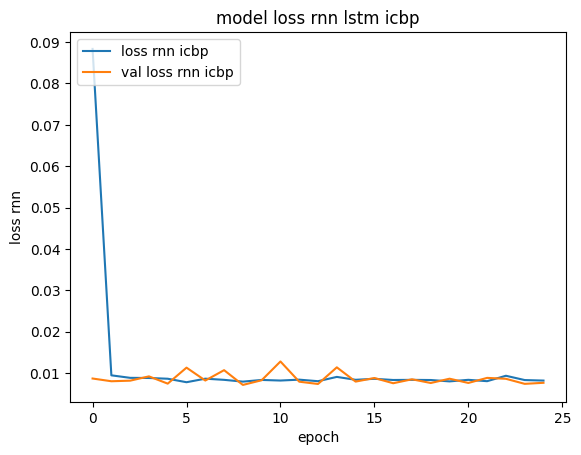

In [116]:
plt.plot(history_icbp_model_rnn.history['loss'], label='loss rnn icbp')
plt.plot(history_icbp_model_rnn.history['val_loss'], label = 'val loss rnn icbp')
plt.title('model loss rnn lstm icbp')
plt.ylabel('loss rnn')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss rnn_icbp', dpi=3600)

## JSMR

In [117]:
#get data and normalize data
df_jsmr_rnn = normalize_data(data_close.jsmr,'jsmr')
#reset index
df_jsmr_rnn = reset_index_data(df_jsmr_rnn)
#data to supervised
jsmr_X_rnn, jsmr_y_rnn = split_sequence(df_jsmr_rnn, 1)
#split to train and test
X_train_jsmr_rnn, X_test_jsmr_rnn, y_train_jsmr_rnn, y_test_jsmr_rnn = train_test_split(jsmr_X_rnn, jsmr_y_rnn, test_size=0.33, random_state=42)

X_train_jsmr_rnn = reshape_data(X_train_jsmr_rnn,1)
X_test_jsmr_rnn = reshape_data(X_test_jsmr_rnn,1)


In [118]:
cfg_jsmr_rnn = [8,'relu',1,1,0.01,16,200]
model_jsmr_rnn,history_jsmr_model_rnn  = train_rnn(X_train_jsmr_rnn,y_train_jsmr_rnn,cfg_jsmr_rnn)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 8)                 80        
                                                                 
 dense_19 (Dense)            (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
105/105 [==============================] - 2s 6ms/step - loss: 0.0618 - mae: 0.0618 - val_loss: 0.0187 - val_mae: 0.0187
Epoch 2/200
105/105 [==============================] - 0s 3ms/step - loss: 0.0144 - mae: 0.0144 - val_loss: 0.0121 - val_mae: 0.0121
Epoch 3/200
105/105 [==============================] - 0s 3ms/step - loss: 0.0138 - mae: 0.0138 - val_loss: 0.0130 - val_mae: 0.0130
Epoch 4/200
105/105 [==============================] -

In [119]:
preds_jsmr_rnn = model_jsmr_rnn.predict(X_test_jsmr_rnn)
matriks_evaluate(preds_jsmr_rnn,y_test_jsmr_rnn,'jsmr',4)

33/33 [==============================] - 0s 2ms/step
Matriks score for jsmr
mae score: 0.011488491514988031
r2 score 0.9942237398867287
mape score 0.031134541626277556
rmse score 0.016155724600024537
round_up
mae score: 0.0115
r2 score 0.9942
mape score 0.0311
rmse score 0.0162


In [120]:
preds_jsmr_rnn_train = model_jsmr_rnn.predict(X_train_jsmr_rnn)
matriks_evaluate(preds_jsmr_rnn_train,y_train_jsmr_rnn,'jsmr',4)

66/66 [==============================] - 0s 2ms/step
Matriks score for jsmr
mae score: 0.012358786144932502
r2 score 0.993333026018637
mape score 0.03193074491139603
rmse score 0.017261697096780867
round_up
mae score: 0.0124
r2 score 0.9933
mape score 0.0319
rmse score 0.0173


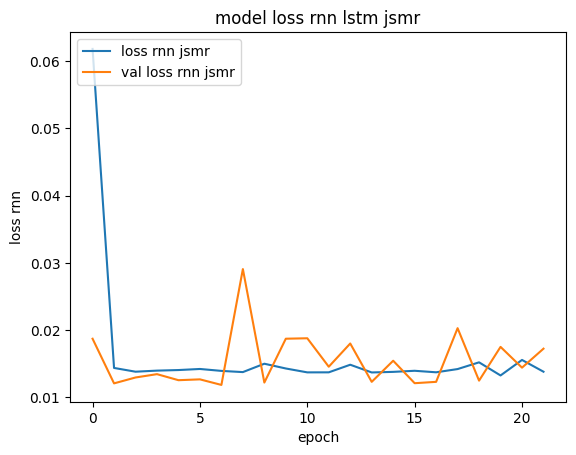

In [121]:
plt.plot(history_jsmr_model_rnn.history['loss'], label='loss rnn jsmr')
plt.plot(history_jsmr_model_rnn.history['val_loss'], label = 'val loss rnn jsmr')
plt.title('model loss rnn lstm jsmr')
plt.ylabel('loss rnn')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss rnn_jsmr', dpi=3600)

# Komparasi berdasarkan Data saham

## ANTM

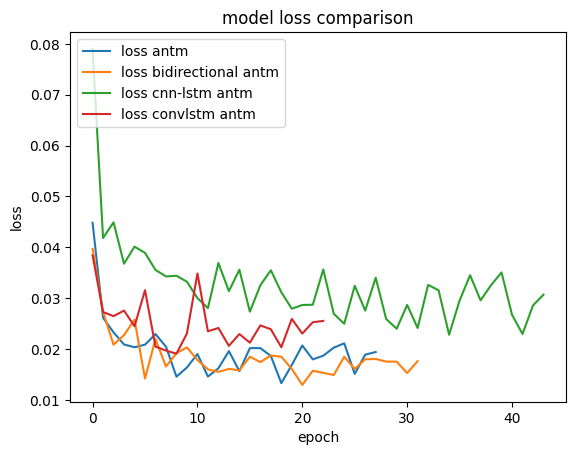

In [122]:
plt.plot(history_antm_model.history['loss'], label='loss antm')
plt.plot(history_antm_model_bidirectional.history['loss'], label='loss bidirectional antm')
plt.plot(history_cnn_antm_model.history['loss'], label='loss cnn-lstm antm')
plt.plot(history_conv_antm_model.history['loss'], label='loss convlstm antm')
plt.title('model loss comparison')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('lstm&rnn_loss_model_comparison_antm', dpi=1200)

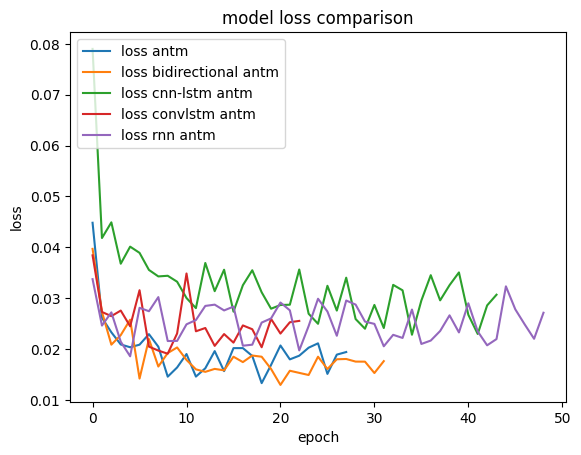

In [123]:
plt.plot(history_antm_model.history['loss'], label='loss antm')
plt.plot(history_antm_model_bidirectional.history['loss'], label='loss bidirectional antm')
plt.plot(history_cnn_antm_model.history['loss'], label='loss cnn-lstm antm')
plt.plot(history_conv_antm_model.history['loss'], label='loss convlstm antm')
plt.plot(history_antm_model_rnn.history['loss'], label='loss rnn antm')
plt.title('model loss comparison')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('lstm&rnn_loss_model_comparison_antm', dpi=3600)

## ASII

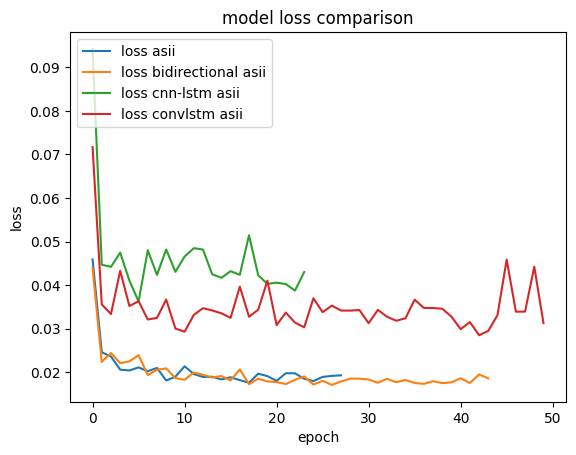

In [124]:
plt.plot(history_asii_model.history['loss'], label='loss asii')
plt.plot(history_asii_model_bidirectional.history['loss'], label='loss bidirectional asii')
plt.plot(history_cnn_asii_model.history['loss'], label='loss cnn-lstm asii')
plt.plot(history_conv_asii_model.history['loss'], label='loss convlstm asii')
plt.title('model loss comparison')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('lstm&rnn_loss_model_comparison_asii', dpi=1200)

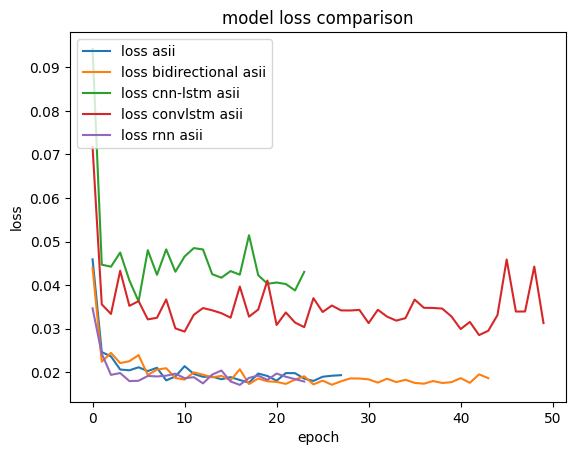

In [125]:
plt.plot(history_asii_model.history['loss'], label='loss asii')
plt.plot(history_asii_model_bidirectional.history['loss'], label='loss bidirectional asii')
plt.plot(history_cnn_asii_model.history['loss'], label='loss cnn-lstm asii')
plt.plot(history_conv_asii_model.history['loss'], label='loss convlstm asii')
plt.plot(history_asii_model_rnn.history['loss'], label='loss rnn asii')
plt.title('model loss comparison')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('lstm&rnn_loss_model_comparison_asii', dpi=3600)

## ICBP

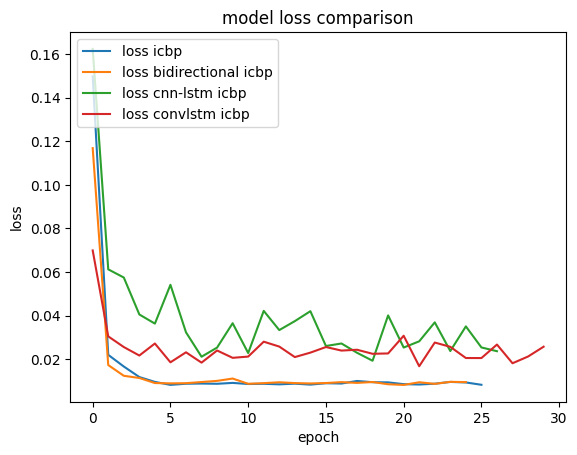

In [126]:
plt.plot(history_icbp_model.history['loss'], label='loss icbp')
plt.plot(history_icbp_model_bidirectional.history['loss'], label='loss bidirectional icbp')
plt.plot(history_cnn_icbp_model.history['loss'], label='loss cnn-lstm icbp')
plt.plot(history_conv_icbp_model.history['loss'], label='loss convlstm icbp')
plt.title('model loss comparison')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('lstm&rnn_loss_model_comparison_icbp', dpi=1200)

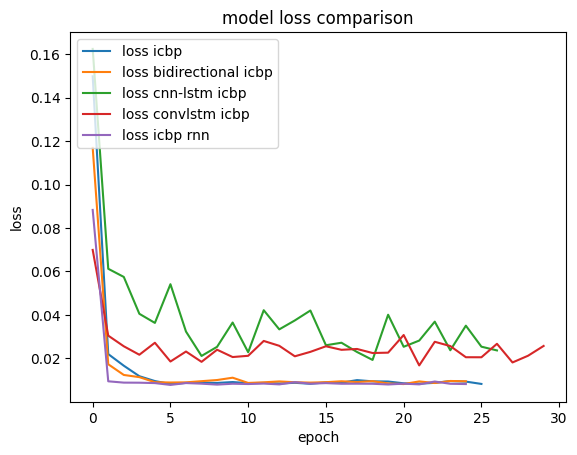

In [127]:
plt.plot(history_icbp_model.history['loss'], label='loss icbp')
plt.plot(history_icbp_model_bidirectional.history['loss'], label='loss bidirectional icbp')
plt.plot(history_cnn_icbp_model.history['loss'], label='loss cnn-lstm icbp')
plt.plot(history_conv_icbp_model.history['loss'], label='loss convlstm icbp')
plt.plot(history_icbp_model_rnn.history['loss'], label='loss icbp rnn')
plt.title('model loss comparison')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('lstm&rnn_loss_model_comparison_icbp', dpi=1200)

## JSMR

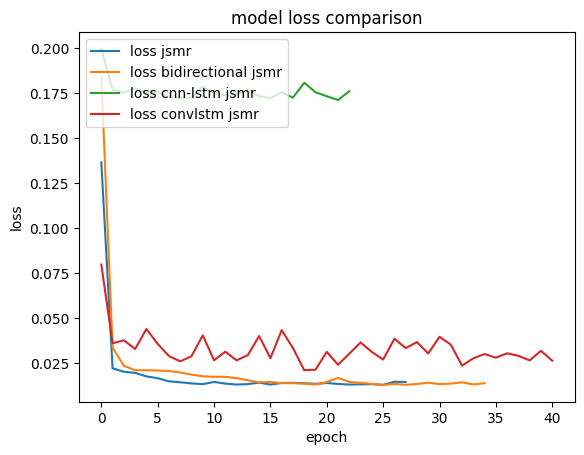

In [128]:
plt.plot(history_jsmr_model.history['loss'], label='loss jsmr')
plt.plot(history_jsmr_model_bidirectional.history['loss'], label='loss bidirectional jsmr')
plt.plot(history_cnn_jsmr_model.history['loss'], label='loss cnn-lstm jsmr')
plt.plot(history_conv_jsmr_model.history['loss'], label='loss convlstm jsmr')
plt.title('model loss comparison')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('lstm&rnn_loss_model_comparison_jsmr', dpi=1200)

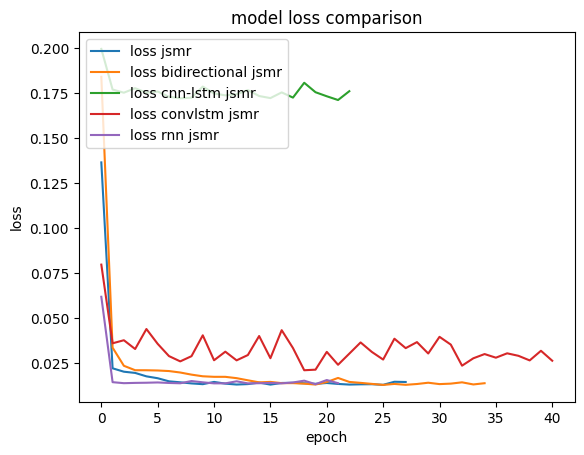

In [129]:
plt.plot(history_jsmr_model.history['loss'], label='loss jsmr')
plt.plot(history_jsmr_model_bidirectional.history['loss'], label='loss bidirectional jsmr')
plt.plot(history_cnn_jsmr_model.history['loss'], label='loss cnn-lstm jsmr')
plt.plot(history_conv_jsmr_model.history['loss'], label='loss convlstm jsmr')
plt.plot(history_jsmr_model_rnn.history['loss'], label='loss rnn jsmr')
plt.title('model loss comparison')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('lstm&rnn_loss_model_comparison_jsmr', dpi=3600)

# KOMPARASI METRIKS EVALUASI Berdasarkan saham

In [130]:
def plot_metriks(data,title):
    names = list(data.keys())
    values = list(data.values())
    plt.title(title)
    plt.bar(range(len(data)), values, tick_label=names)
    plt.savefig(title, dpi=1200)
    plt.show()

## ANTM

In [131]:
mae_antm_model = {'model\nlstm\nantm':mean_absolute_error(preds_antm, y_test_antm),'model\nbidirectional\nlstm':mean_absolute_error(preds_antm_bidirectional, y_test_antm),'model\ncnn\nlstm':mean_absolute_error(preds_antm_cnn_lstm, y_test_antm_cnn),'model\nconvlstm':mean_absolute_error(preds_antm_conv_lstm, y_test_antm_conv)}

mape_antm_model = {'model\nlstm\nantm':mean_absolute_percentage_error(preds_antm, y_test_antm),'model\nbidirectional\nlstm':mean_absolute_percentage_error(preds_antm_bidirectional, y_test_antm),'model\ncnn\nlstm':mean_absolute_percentage_error(preds_antm_cnn_lstm, y_test_antm_cnn),'model\nconvlstm':mean_absolute_percentage_error(preds_antm_conv_lstm, y_test_antm_conv)}

rmse_antm_model = {'model\nlstm\nantm':np.sqrt(mean_squared_error(preds_antm, y_test_antm)),'model\nbidirectional\nlstm':np.sqrt(mean_squared_error(preds_antm_bidirectional, y_test_antm)),'model\ncnn\nlstm':np.sqrt(mean_squared_error(preds_antm_cnn_lstm, y_test_antm_cnn)),'model\nconvlstm':np.sqrt(mean_squared_error(preds_antm_conv_lstm, y_test_antm_conv))}

r2_antm_model = {'model\nlstm\nantm':r2_score(preds_antm, y_test_antm),'model\nbidirectional\nlstm':r2_score(preds_antm_bidirectional, y_test_antm),'model\ncnn\nlstm':r2_score(preds_antm_cnn_lstm, y_test_antm_cnn),'model\nconvlstm':r2_score(preds_antm_conv_lstm, y_test_antm_conv)} 


In [132]:
mae_antm_model_rnn = {'model\nlstm\nantm':mean_absolute_error(preds_antm, y_test_antm),'model\nbidirectional\nlstm':mean_absolute_error(preds_antm_bidirectional, y_test_antm),'model\ncnn\nlstm':mean_absolute_error(preds_antm_cnn_lstm, y_test_antm_cnn),'model\nconvlstm':mean_absolute_error(preds_antm_conv_lstm, y_test_antm_conv),'model\nrnn':mean_absolute_error(preds_antm_rnn, y_test_antm_rnn)}

mape_antm_model_rnn = {'model\nlstm\nantm':mean_absolute_percentage_error(preds_antm, y_test_antm),'model\nbidirectional\nlstm':mean_absolute_percentage_error(preds_antm_bidirectional, y_test_antm),'model\ncnn\nlstm':mean_absolute_percentage_error(preds_antm_cnn_lstm, y_test_antm_cnn),'model\nconvlstm':mean_absolute_percentage_error(preds_antm_conv_lstm, y_test_antm_conv),'model\nrnn':mean_absolute_percentage_error(preds_antm_rnn, y_test_antm_rnn)}

rmse_antm_model_rnn = {'model\nlstm\nantm':np.sqrt(mean_squared_error(preds_antm, y_test_antm)),'model\nbidirectional\nlstm':np.sqrt(mean_squared_error(preds_antm_bidirectional, y_test_antm)),'model\ncnn\nlstm':np.sqrt(mean_squared_error(preds_antm_cnn_lstm, y_test_antm_cnn)),'model\nconvlstm':np.sqrt(mean_squared_error(preds_antm_conv_lstm, y_test_antm_conv)),'model\nrnn':np.sqrt(mean_squared_error(preds_antm_rnn, y_test_antm_rnn))}

r2_antm_model_rnn = {'model\nlstm\nantm':r2_score(preds_antm, y_test_antm),'model\nbidirectional\nlstm':r2_score(preds_antm_bidirectional, y_test_antm),'model\ncnn\nlstm':r2_score(preds_antm_cnn_lstm, y_test_antm_cnn),'model\nconvlstm':r2_score(preds_antm_conv_lstm, y_test_antm_conv),'model\nrnn':r2_score(preds_antm_rnn, y_test_antm_rnn)} 


In [133]:
print("sorted mae")
mae_antm_sorted = dict(sorted(mae_antm_model.items(),key=lambda item: item[1]))
print(mae_antm_sorted)
print("sorted rmse")
rmse_antm_sorted = dict(sorted(rmse_antm_model.items(),key=lambda item: item[1]))
print(rmse_antm_sorted)
print("sorted mape")
mape_antm_sorted = dict(sorted(mape_antm_model.items(),key=lambda item: item[1]))
print(mape_antm_sorted)
print("sorted r2")
r2_antm_sorted = dict(sorted(r2_antm_model.items(),key=lambda item: item[1] ,reverse=True))
print(r2_antm_sorted)

sorted mae
{'model\nbidirectional\nlstm': 0.008622911295103711, 'model\nlstm\nantm': 0.008657112310047916, 'model\nconvlstm': 0.00949778272261078, 'model\ncnn\nlstm': 0.011021294974423265}
sorted rmse
{'model\nlstm\nantm': 0.014420858182332697, 'model\nbidirectional\nlstm': 0.01469868797014148, 'model\nconvlstm': 0.015957795428146876, 'model\ncnn\nlstm': 0.018218946325348633}
sorted mape
{'model\nbidirectional\nlstm': 0.03656672718775695, 'model\nlstm\nantm': 0.04446788611987502, 'model\nconvlstm': 0.04760711790058863, 'model\ncnn\nlstm': 0.06398360991337543}
sorted r2
{'model\nbidirectional\nlstm': 0.9947014825333139, 'model\nlstm\nantm': 0.9945017262756606, 'model\nconvlstm': 0.9937580542432792, 'model\ncnn\nlstm': 0.9916091934160977}


In [134]:
sorted mae
{'model_lstm_antm': 0.00792330651423234, 'model_convlstm': 0.008979813932403035, 'model_bidirectional_lstm': 0.010083131140679802, 'model_cnn_lstm': 0.010867278830534548}
sorted rmse
{'model_lstm_antm': 0.013645817005473931, 'model_bidirectional_lstm': 0.015164592497452231, 'model_convlstm': 0.015586941316141424, 'model_cnn_lstm': 0.016741492746486068}
sorted mape
{'model_lstm_antm': 0.03875965710274557, 'model_convlstm': 0.04170634238737134, 'model_cnn_lstm': 0.064639021568424, 'model_bidirectional_lstm': 0.07193945105344311}
sorted r2
{'model_lstm_antm': 0.9951434537789272, 'model_convlstm': 0.9940666469044093, 'model_bidirectional_lstm': 0.9937322524708159, 'model_cnn_lstm': 0.993089376712622}

SyntaxError: invalid syntax (2735729168.py, line 1)

In [ ]:
print("sorted mae with rnn")
mae_antm_sorted_rnn = dict(sorted(mae_antm_model_rnn.items(),key=lambda item: item[1]))
print(mae_antm_sorted_rnn)
print("sorted rmse with rnn")
rmse_antm_sorted_rnn = dict(sorted(rmse_antm_model_rnn.items(),key=lambda item: item[1]))
print(rmse_antm_sorted_rnn)
print("sorted mape with rnn")
mape_antm_sorted_rnn = dict(sorted(mape_antm_model_rnn.items(),key=lambda item: item[1]))
print(mape_antm_sorted_rnn)
print("sorted r2 with rnn")
r2_antm_sorted_rnn = dict(sorted(r2_antm_model_rnn.items(),key=lambda item: item[1] ,reverse=True))
print(r2_antm_sorted_rnn)

sorted mae with rnn
{'model\nlstm\nantm': 0.00792330651423234, 'model\nconvlstm': 0.008979813932403035, 'model\nbidirectional\nlstm': 0.010083131140679802, 'model\nrnn': 0.010478654205229577, 'model\ncnn\nlstm': 0.010867278830534548}
sorted rmse with rnn
{'model\nlstm\nantm': 0.013645817005473931, 'model\nbidirectional\nlstm': 0.015164592497452231, 'model\nconvlstm': 0.015586941316141424, 'model\nrnn': 0.015870582918009215, 'model\ncnn\nlstm': 0.016741492746486068}
sorted mape with rnn
{'model\nlstm\nantm': 0.03875965710274557, 'model\nconvlstm': 0.04170634238737134, 'model\nrnn': 0.05973322659954254, 'model\ncnn\nlstm': 0.064639021568424, 'model\nbidirectional\nlstm': 0.07193945105344311}
sorted r2 with rnn
{'model\nlstm\nantm': 0.9951434537789272, 'model\nconvlstm': 0.9940666469044093, 'model\nrnn': 0.9938764452484279, 'model\nbidirectional\nlstm': 0.9937322524708159, 'model\ncnn\nlstm': 0.993089376712622}


In [ ]:
sorted mae with rnn
{'model_lstm_antm': 0.00792330651423234, 'model_convlstm': 0.008979813932403035, 'model_bidirectional_lstm': 0.010083131140679802, 'model_rnn': 0.010478654205229577, 'model_cnn_lstm': 0.010867278830534548}
sorted rmse with rnn
{'model_lstm_antm': 0.013645817005473931, 'model_bidirectional_lstm': 0.015164592497452231, 'model_convlstm': 0.015586941316141424, 'model_rnn': 0.015870582918009215, 'model_cnn_lstm': 0.016741492746486068}
sorted mape with rnn
{'model_lstm_antm': 0.03875965710274557, 'model_convlstm': 0.04170634238737134, 'model_rnn': 0.05973322659954254, 'model_cnn_lstm': 0.064639021568424, 'model_bidirectional_lstm': 0.07193945105344311}
sorted r2 with rnn
{'model_lstm_antm': 0.9951434537789272, 'model_convlstm': 0.9940666469044093, 'model_rnn': 0.9938764452484279, 'model_bidirectional_lstm': 0.9937322524708159, 'model_cnn_lstm': 0.993089376712622}

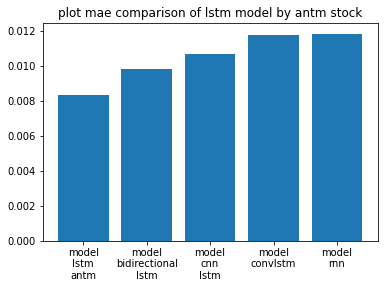

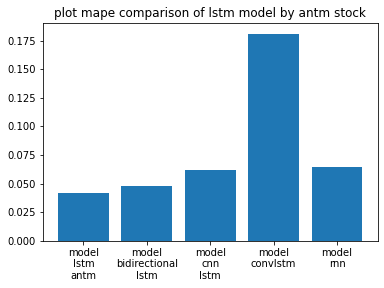

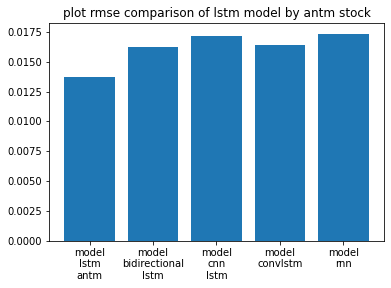

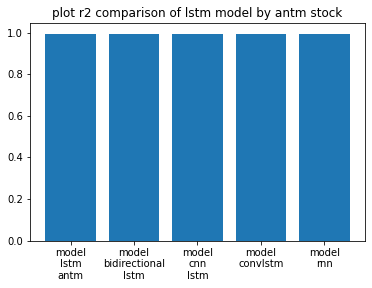

In [ ]:
plot_metriks(mae_antm_model,"plot mae comparison of lstm model by antm stock")
plot_metriks(mape_antm_model,"plot mape comparison of lstm model by antm stock")
plot_metriks(rmse_antm_model,"plot rmse comparison of lstm model by antm stock")
plot_metriks(r2_antm_model,"plot r2 comparison of lstm model by antm stock")

## ASII

In [ ]:
mae_asii_model = {'model\nlstm\nasii':mean_absolute_error(preds_asii, y_test_asii),'model\nbidirectional\nlstm':mean_absolute_error(preds_asii_bidirectional, y_test_asii),'model\ncnn\nlstm':mean_absolute_error(preds_asii_cnn_lstm, y_test_asii_cnn),'model\nconvlstm':mean_absolute_error(preds_asii_conv_lstm, y_test_asii_conv)}

mape_asii_model = {'model\nlstm\nasii':mean_absolute_percentage_error(preds_asii, y_test_asii),'model\nbidirectional\nlstm':mean_absolute_percentage_error(preds_asii_bidirectional, y_test_asii),'model\ncnn\nlstm':mean_absolute_percentage_error(preds_asii_cnn_lstm, y_test_asii_cnn),'model\nconvlstm':mean_absolute_percentage_error(preds_asii_conv_lstm, y_test_asii_conv)}

rmse_asii_model = {'model\nlstm\nasii':np.sqrt(mean_squared_error(preds_asii, y_test_asii)),'model\nbidirectional\nlstm':np.sqrt(mean_squared_error(preds_asii_bidirectional, y_test_asii)),'model\ncnn\nlstm':np.sqrt(mean_squared_error(preds_asii_cnn_lstm, y_test_asii_cnn)),'model\nconvlstm':np.sqrt(mean_squared_error(preds_asii_conv_lstm, y_test_asii_conv))}

r2_asii_model = {'model\nlstm\nasii':r2_score(preds_asii, y_test_asii),'model\nbidirectional\nlstm':r2_score(preds_asii_bidirectional, y_test_asii),'model\ncnn\nlstm':r2_score(preds_asii_cnn_lstm, y_test_asii_cnn),'model\nconvlstm':r2_score(preds_asii_conv_lstm, y_test_asii_conv)} 


In [ ]:
mae_asii_model_rnn = {'model\nlstm\nasii':mean_absolute_error(preds_asii, y_test_asii),'model\nbidirectional\nlstm':mean_absolute_error(preds_asii_bidirectional, y_test_asii),'model\ncnn\nlstm':mean_absolute_error(preds_asii_cnn_lstm, y_test_asii_cnn),'model\nconvlstm':mean_absolute_error(preds_asii_conv_lstm, y_test_asii_conv),'model\nrnn':mean_absolute_error(preds_asii_rnn, y_test_asii_rnn)}

mape_asii_model_rnn = {'model\nlstm\nasii':mean_absolute_percentage_error(preds_asii, y_test_asii),'model\nbidirectional\nlstm':mean_absolute_percentage_error(preds_asii_bidirectional, y_test_asii),'model\ncnn\nlstm':mean_absolute_percentage_error(preds_asii_cnn_lstm, y_test_asii_cnn),'model\nconvlstm':mean_absolute_percentage_error(preds_asii_conv_lstm, y_test_asii_conv),'model\nrnn':mean_absolute_percentage_error(preds_asii_rnn, y_test_asii_rnn)}

rmse_asii_model_rnn = {'model\nlstm\nasii':np.sqrt(mean_squared_error(preds_asii, y_test_asii)),'model\nbidirectional\nlstm':np.sqrt(mean_squared_error(preds_asii_bidirectional, y_test_asii)),'model\ncnn\nlstm':np.sqrt(mean_squared_error(preds_asii_cnn_lstm, y_test_asii_cnn)),'model\nconvlstm':np.sqrt(mean_squared_error(preds_asii_conv_lstm, y_test_asii_conv)),'model\nrnn':np.sqrt(mean_squared_error(preds_asii_rnn, y_test_asii_rnn))}

r2_asii_model_rnn = {'model\nlstm\nasii':r2_score(preds_asii, y_test_asii),'model\nbidirectional\nlstm':r2_score(preds_asii_bidirectional, y_test_asii),'model\ncnn\nlstm':r2_score(preds_asii_cnn_lstm, y_test_asii_cnn),'model\nconvlstm':r2_score(preds_asii_conv_lstm, y_test_asii_conv),'model\nrnn':r2_score(preds_asii_rnn, y_test_asii_rnn)} 


In [ ]:
print("sorted mae")
mae_asii_sorted = dict(sorted(mae_asii_model.items(),key=lambda item: item[1]))
print(mae_asii_sorted)
print("sorted rmse")
rmse_asii_sorted = dict(sorted(rmse_asii_model.items(),key=lambda item: item[1]))
print(rmse_asii_sorted)
print("sorted mape")
mape_asii_sorted = dict(sorted(mape_asii_model.items(),key=lambda item: item[1]))
print(mape_asii_sorted)
print("sorted r2")
r2_asii_sorted = dict(sorted(r2_asii_model.items(),key=lambda item: item[1] ,reverse=True))
print(r2_asii_sorted)

sorted mae
{'model\nlstm\nasii': 0.015557469024060277, 'model\nbidirectional\nlstm': 0.015557469024060277, 'model\nconvlstm': 0.017502466607205686, 'model\ncnn\nlstm': 0.025615471457232676}
sorted rmse
{'model\nlstm\nasii': 0.020195572184998862, 'model\nbidirectional\nlstm': 0.020195572184998862, 'model\nconvlstm': 0.024368460318503666, 'model\ncnn\nlstm': 0.034314310609913}
sorted mape
{'model\nlstm\nasii': 0.03653063088132113, 'model\nbidirectional\nlstm': 0.03653063088132113, 'model\nconvlstm': 0.04371383500044023, 'model\ncnn\nlstm': 0.09404178861648758}
sorted r2
{'model\nlstm\nasii': 0.989093802259257, 'model\nbidirectional\nlstm': 0.989093802259257, 'model\nconvlstm': 0.9845989847390949, 'model\ncnn\nlstm': 0.9706884687600915}


In [ ]:
sorted mae
{'model_lstm_asii': 0.015557469024060277, 'model_bidirectional_lstm': 0.015557469024060277, 'model_convlstm': 0.017502466607205686, 'model_cnn_lstm': 0.025615471457232676}
sorted rmse
{'model_lstm_asii': 0.020195572184998862, 'model_bidirectional_lstm': 0.020195572184998862, 'model_convlstm': 0.024368460318503666, 'model_cnn_lstm': 0.034314310609913}
sorted mape
{'model_lstm_asii': 0.03653063088132113, 'model_bidirectional_lstm': 0.03653063088132113, 'model_convlstm': 0.04371383500044023, 'model_cnn_lstm': 0.09404178861648758}
sorted r2
{'model_lstm_asii': 0.989093802259257, 'model_bidirectional_lstm': 0.989093802259257, 'model_convlstm': 0.9845989847390949, 'model_cnn_lstm': 0.9706884687600915}

In [ ]:
print("sorted mae")
mae_asii_sorted = dict(sorted(mae_asii_model.items(),key=lambda item: item[1]))
print(mae_asii_sorted)
print("sorted rmse")
rmse_asii_sorted = dict(sorted(rmse_asii_model.items(),key=lambda item: item[1]))
print(rmse_asii_sorted)
print("sorted mape")
mape_asii_sorted = dict(sorted(mape_asii_model.items(),key=lambda item: item[1]))
print(mape_asii_sorted)
print("sorted r2")
r2_asii_sorted = dict(sorted(r2_asii_model.items(),key=lambda item: item[1] ,reverse=True))
print(r2_asii_sorted)

sorted mae
{'model\nlstm\nasii': 0.015557469024060277, 'model\nbidirectional\nlstm': 0.015557469024060277, 'model\nrnn': 0.016422883454755, 'model\nconvlstm': 0.017502466607205686, 'model\ncnn\nlstm': 0.025615471457232676}
sorted rmse
{'model\nlstm\nasii': 0.020195572184998862, 'model\nbidirectional\nlstm': 0.020195572184998862, 'model\nrnn': 0.02181020099368869, 'model\nconvlstm': 0.024368460318503666, 'model\ncnn\nlstm': 0.034314310609913}
sorted mape
{'model\nlstm\nasii': 0.03653063088132113, 'model\nbidirectional\nlstm': 0.03653063088132113, 'model\nconvlstm': 0.04371383500044023, 'model\nrnn': 0.060887043105124335, 'model\ncnn\nlstm': 0.09404178861648758}
sorted r2
{'model\nlstm\nasii': 0.989093802259257, 'model\nbidirectional\nlstm': 0.989093802259257, 'model\nrnn': 0.9887014235433372, 'model\nconvlstm': 0.9845989847390949, 'model\ncnn\nlstm': 0.9706884687600915}


In [ ]:
print("sorted mae with rnn")
mae_asii_sorted_rnn = dict(sorted(mae_asii_model_rnn.items(),key=lambda item: item[1]))
print(mae_asii_sorted_rnn)
print("sorted rmse with rnn")
rmse_asii_sorted_rnn = dict(sorted(rmse_asii_model_rnn.items(),key=lambda item: item[1]))
print(rmse_asii_sorted_rnn)
print("sorted mape with rnn")
mape_asii_sorted_rnn = dict(sorted(mape_asii_model_rnn.items(),key=lambda item: item[1]))
print(mape_asii_sorted_rnn)
print("sorted r2 with rnn")
r2_asii_sorted_rnn = dict(sorted(r2_asii_model_rnn.items(),key=lambda item: item[1] ,reverse=True))
print(r2_asii_sorted_rnn)

sorted mae with rnn
{'model\nlstm\nasii': 0.015557469024060277, 'model\nbidirectional\nlstm': 0.015557469024060277, 'model\nrnn': 0.016422883454755, 'model\nconvlstm': 0.017502466607205686, 'model\ncnn\nlstm': 0.025615471457232676}
sorted rmse with rnn
{'model\nlstm\nasii': 0.020195572184998862, 'model\nbidirectional\nlstm': 0.020195572184998862, 'model\nrnn': 0.02181020099368869, 'model\nconvlstm': 0.024368460318503666, 'model\ncnn\nlstm': 0.034314310609913}
sorted mape with rnn
{'model\nlstm\nasii': 0.03653063088132113, 'model\nbidirectional\nlstm': 0.03653063088132113, 'model\nconvlstm': 0.04371383500044023, 'model\nrnn': 0.060887043105124335, 'model\ncnn\nlstm': 0.09404178861648758}
sorted r2 with rnn
{'model\nlstm\nasii': 0.989093802259257, 'model\nbidirectional\nlstm': 0.989093802259257, 'model\nrnn': 0.9887014235433372, 'model\nconvlstm': 0.9845989847390949, 'model\ncnn\nlstm': 0.9706884687600915}


In [ ]:
sorted mae with rnn
{'model_lstm_asii': 0.015557469024060277, 'model_bidirectional_lstm': 0.015557469024060277, 'model_rnn': 0.016422883454755, 'model_convlstm': 0.017502466607205686, 'model_cnn_lstm': 0.025615471457232676}
sorted rmse with rnn
{'model_lstm_asii': 0.020195572184998862, 'model_bidirectional_lstm': 0.020195572184998862, 'model_rnn': 0.02181020099368869, 'model_convlstm': 0.024368460318503666, 'model_cnn_lstm': 0.034314310609913}
sorted mape with rnn
{'model_lstm_asii': 0.03653063088132113, 'model_bidirectional_lstm': 0.03653063088132113, 'model_convlstm': 0.04371383500044023, 'model_rnn': 0.060887043105124335, 'model_cnn_lstm': 0.09404178861648758}
sorted r2 with rnn
{'model_lstm_asii': 0.989093802259257, 'model_bidirectional_lstm': 0.989093802259257, 'model_rnn': 0.9887014235433372, 'model_convlstm': 0.9845989847390949, 'model_cnn_lstm': 0.9706884687600915}

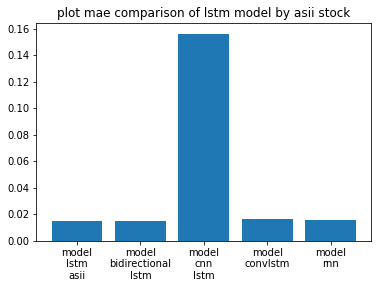

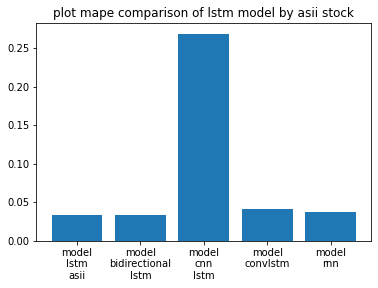

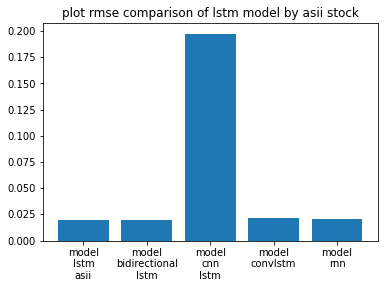

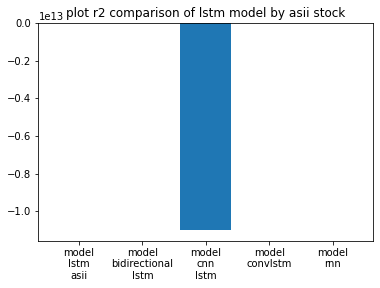

In [ ]:
plot_metriks(mae_asii_model,"plot mae comparison of lstm model by asii stock")
plot_metriks(mape_asii_model,"plot mape comparison of lstm model by asii stock")
plot_metriks(rmse_asii_model,"plot rmse comparison of lstm model by asii stock")
plot_metriks(r2_asii_model,"plot r2 comparison of lstm model by asii stock")

## ICBP

In [ ]:
mae_icbp_model = {'model\nlstm\nicbp':mean_absolute_error(preds_icbp, y_test_icbp),'model\nbidirectional\nlstm':mean_absolute_error(preds_icbp_bidirectional, y_test_icbp),'model\ncnn\nlstm':mean_absolute_error(preds_icbp_cnn_lstm, y_test_icbp_cnn),'model\nconvlstm':mean_absolute_error(preds_icbp_conv_lstm, y_test_icbp_conv)}

mape_icbp_model = {'model\nlstm\nicbp':mean_absolute_percentage_error(preds_icbp, y_test_icbp),'model\nbidirectional\nlstm':mean_absolute_percentage_error(preds_icbp_bidirectional, y_test_icbp),'model\ncnn\nlstm':mean_absolute_percentage_error(preds_icbp_cnn_lstm, y_test_icbp_cnn),'model\nconvlstm':mean_absolute_percentage_error(preds_icbp_conv_lstm, y_test_icbp_conv),}

rmse_icbp_model = {'model\nlstm\nicbp':np.sqrt(mean_squared_error(preds_icbp, y_test_icbp)),'model\nbidirectional\nlstm':np.sqrt(mean_squared_error(preds_icbp_bidirectional, y_test_icbp)),'model\ncnn\nlstm':np.sqrt(mean_squared_error(preds_icbp_cnn_lstm, y_test_icbp_cnn)),'model\nconvlstm':np.sqrt(mean_squared_error(preds_icbp_conv_lstm, y_test_icbp_conv))}

r2_icbp_model = {'model\nlstm\nicbp':r2_score(preds_icbp, y_test_icbp),'model\nbidirectional\nlstm':r2_score(preds_icbp_bidirectional, y_test_icbp),'model\ncnn\nlstm':r2_score(preds_icbp_cnn_lstm, y_test_icbp_cnn),'model\nconvlstm':r2_score(preds_icbp_conv_lstm, y_test_icbp_conv)} 


In [ ]:
mae_icbp_model_rnn = {'model\nlstm\nicbp':mean_absolute_error(preds_icbp, y_test_icbp),'model\nbidirectional\nlstm':mean_absolute_error(preds_icbp_bidirectional, y_test_icbp),'model\ncnn\nlstm':mean_absolute_error(preds_icbp_cnn_lstm, y_test_icbp_cnn),'model\nconvlstm':mean_absolute_error(preds_icbp_conv_lstm, y_test_icbp_conv),'model\nrnn':mean_absolute_error(preds_icbp_rnn, y_test_icbp_rnn)}

mape_icbp_model_rnn = {'model\nlstm\nicbp':mean_absolute_percentage_error(preds_icbp, y_test_icbp),'model\nbidirectional\nlstm':mean_absolute_percentage_error(preds_icbp_bidirectional, y_test_icbp),'model\ncnn\nlstm':mean_absolute_percentage_error(preds_icbp_cnn_lstm, y_test_icbp_cnn),'model\nconvlstm':mean_absolute_percentage_error(preds_icbp_conv_lstm, y_test_icbp_conv),'model\nrnn':mean_absolute_percentage_error(preds_icbp_rnn, y_test_icbp_rnn)}

rmse_icbp_model_rnn = {'model\nlstm\nicbp':np.sqrt(mean_squared_error(preds_icbp, y_test_icbp)),'model\nbidirectional\nlstm':np.sqrt(mean_squared_error(preds_icbp_bidirectional, y_test_icbp)),'model\ncnn\nlstm':np.sqrt(mean_squared_error(preds_icbp_cnn_lstm, y_test_icbp_cnn)),'model\nconvlstm':np.sqrt(mean_squared_error(preds_icbp_conv_lstm, y_test_icbp_conv)),'model\nrnn':np.sqrt(mean_squared_error(preds_icbp_rnn, y_test_icbp_rnn))}

r2_icbp_model_rnn = {'model\nlstm\nicbp':r2_score(preds_icbp, y_test_icbp),'model\nbidirectional\nlstm':r2_score(preds_icbp_bidirectional, y_test_icbp),'model\ncnn\nlstm':r2_score(preds_icbp_cnn_lstm, y_test_icbp_cnn),'model\nconvlstm':r2_score(preds_icbp_conv_lstm, y_test_icbp_conv),'model\nrnn':r2_score(preds_icbp_rnn, y_test_icbp_rnn)} 


In [ ]:
print("sorted mae")
mae_icbp_sorted = dict(sorted(mae_icbp_model.items(),key=lambda item: item[1]))
print(mae_icbp_sorted)
print("sorted rmse")
rmse_icbp_sorted = dict(sorted(rmse_icbp_model.items(),key=lambda item: item[1]))
print(rmse_icbp_sorted)
print("sorted mape")
mape_icbp_sorted = dict(sorted(mape_icbp_model.items(),key=lambda item: item[1]))
print(mape_icbp_sorted)
print("sorted r2")
r2_icbp_sorted = dict(sorted(r2_icbp_model.items(),key=lambda item: item[1] ,reverse=True))
print(r2_icbp_sorted)

sorted mae
{'model\nlstm\nicbp': 0.007648942956731045, 'model\nbidirectional\nlstm': 0.007648942956731045, 'model\nconvlstm': 0.008220928696773062, 'model\ncnn\nlstm': 0.009556431471032486}
sorted rmse
{'model\nlstm\nicbp': 0.011935327146399034, 'model\nbidirectional\nlstm': 0.011935327146399034, 'model\nconvlstm': 0.01194496498690776, 'model\ncnn\nlstm': 0.014560457730640828}
sorted mape
{'model\nlstm\nicbp': 0.030918351015072346, 'model\nbidirectional\nlstm': 0.030918351015072346, 'model\nconvlstm': 0.03313670493828922, 'model\ncnn\nlstm': 0.040972101408647904}
sorted r2
{'model\nlstm\nicbp': 0.9981788616019397, 'model\nbidirectional\nlstm': 0.9981788616019397, 'model\nconvlstm': 0.9981439306391389, 'model\ncnn\nlstm': 0.9970308200983052}


In [ ]:
sorted mae
{'model_lstm_icbp': 0.007648942956731045, 'model_bidirectional_lstm': 0.007648942956731045, 'model_convlstm': 0.008220928696773062, 'model_cnn_lstm': 0.009556431471032486}
sorted rmse
{'model_lstm_icbp': 0.011935327146399034, 'model_bidirectional_lstm': 0.011935327146399034, 'model_convlstm': 0.01194496498690776, 'model_cnn_lstm': 0.014560457730640828}
sorted mape
{'model_lstm_icbp': 0.030918351015072346, 'model_bidirectional_lstm': 0.030918351015072346, 'model_convlstm': 0.03313670493828922, 'model_cnn_lstm': 0.040972101408647904}
sorted r2
{'model_lstm_icbp': 0.9981788616019397, 'model_bidirectional_lstm': 0.9981788616019397, 'model_convlstm': 0.9981439306391389, 'model_cnn_lstm': 0.9970308200983052}

In [ ]:
print("sorted mae with rnn")
mae_icbp_sorted_rnn = dict(sorted(mae_icbp_model_rnn.items(),key=lambda item: item[1]))
print(mae_icbp_sorted_rnn)
print("sorted rmse with rnn")
rmse_icbp_sorted_rnn = dict(sorted(rmse_icbp_model_rnn.items(),key=lambda item: item[1]))
print(rmse_icbp_sorted_rnn)
print("sorted mape with rnn")
mape_icbp_sorted_rnn = dict(sorted(mape_icbp_model_rnn.items(),key=lambda item: item[1]))
print(mape_icbp_sorted_rnn)
print("sorted r2 with rnn")
r2_icbp_sorted_rnn = dict(sorted(r2_icbp_model_rnn.items(),key=lambda item: item[1] ,reverse=True))
print(r2_icbp_sorted_rnn)

sorted mae with rnn
{'model\nlstm\nicbp': 0.007648942956731045, 'model\nbidirectional\nlstm': 0.007648942956731045, 'model\nrnn': 0.007757285320692215, 'model\nconvlstm': 0.008220928696773062, 'model\ncnn\nlstm': 0.009556431471032486}
sorted rmse with rnn
{'model\nlstm\nicbp': 0.011935327146399034, 'model\nbidirectional\nlstm': 0.011935327146399034, 'model\nconvlstm': 0.01194496498690776, 'model\nrnn': 0.01200580053690187, 'model\ncnn\nlstm': 0.014560457730640828}
sorted mape with rnn
{'model\nrnn': 0.028233230604920338, 'model\nlstm\nicbp': 0.030918351015072346, 'model\nbidirectional\nlstm': 0.030918351015072346, 'model\nconvlstm': 0.03313670493828922, 'model\ncnn\nlstm': 0.040972101408647904}
sorted r2 with rnn
{'model\nrnn': 0.9982025783014885, 'model\nlstm\nicbp': 0.9981788616019397, 'model\nbidirectional\nlstm': 0.9981788616019397, 'model\nconvlstm': 0.9981439306391389, 'model\ncnn\nlstm': 0.9970308200983052}


In [ ]:
sorted mae with rnn
{'model_lstm_icbp': 0.007648942956731045, 'model_bidirectional_lstm': 0.007648942956731045, 'model_rnn': 0.007757285320692215, 'model_convlstm': 0.008220928696773062, 'model_cnn_lstm': 0.009556431471032486}
sorted rmse with rnn
{'model_lstm_icbp': 0.011935327146399034, 'model_bidirectional_lstm': 0.011935327146399034, 'model_convlstm': 0.01194496498690776, 'model_rnn': 0.01200580053690187, 'model_cnn_lstm': 0.014560457730640828}
sorted mape with rnn
{'model_rnn': 0.028233230604920338, 'model_lstm_icbp': 0.030918351015072346, 'model_bidirectional_lstm': 0.030918351015072346, 'model_convlstm': 0.03313670493828922, 'model_cnn_lstm': 0.040972101408647904}
sorted r2 with rnn
{'model_rnn': 0.9982025783014885, 'model_lstm_icbp': 0.9981788616019397, 'model_bidirectional_lstm': 0.9981788616019397, 'model_convlstm': 0.9981439306391389, 'model_cnn_lstm': 0.9970308200983052}

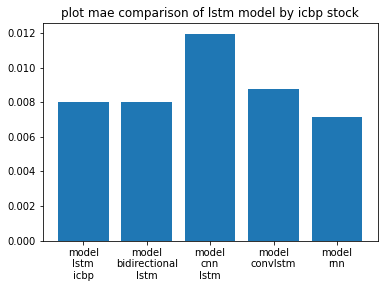

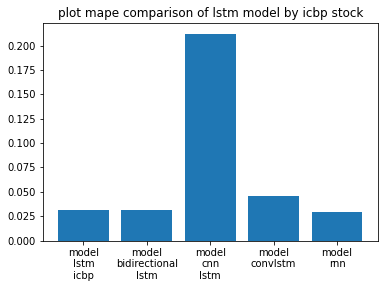

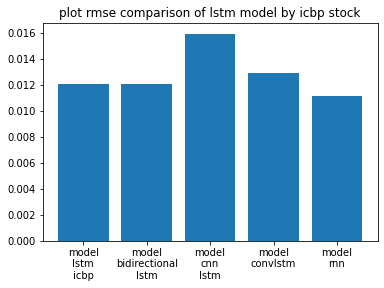

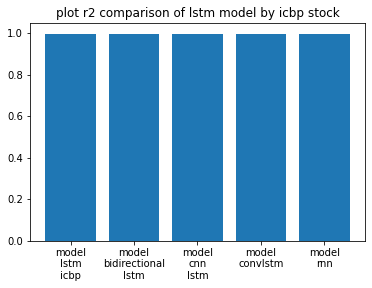

In [ ]:
plot_metriks(mae_icbp_model,"plot mae comparison of lstm model by icbp stock")
plot_metriks(mape_icbp_model,"plot mape comparison of lstm model by icbp stock")
plot_metriks(rmse_icbp_model,"plot rmse comparison of lstm model by icbp stock")
plot_metriks(r2_icbp_model,"plot r2 comparison of lstm model by icbp stock")

## JSMR

In [ ]:
mae_jsmr_model = {'model\nlstm\njsmr':mean_absolute_error(preds_jsmr, y_test_jsmr),'model\nbidirectional\nlstm':mean_absolute_error(preds_jsmr_bidirectional, y_test_jsmr),'model\ncnn\nlstm':mean_absolute_error(preds_jsmr_cnn_lstm, y_test_jsmr_cnn),'model\nconvlstm':mean_absolute_error(preds_jsmr_conv_lstm, y_test_jsmr_conv)}

mape_jsmr_model = {'model\nlstm\njsmr':mean_absolute_percentage_error(preds_jsmr, y_test_jsmr),'model\nbidirectional\nlstm':mean_absolute_percentage_error(preds_jsmr_bidirectional, y_test_jsmr),'model\ncnn\nlstm':mean_absolute_percentage_error(preds_jsmr_cnn_lstm, y_test_jsmr_cnn),'model\nconvlstm':mean_absolute_percentage_error(preds_jsmr_conv_lstm, y_test_jsmr_conv),}

rmse_jsmr_model = {'model\nlstm\njsmr':np.sqrt(mean_squared_error(preds_jsmr, y_test_jsmr)),'model\nbidirectional\nlstm':np.sqrt(mean_squared_error(preds_jsmr_bidirectional, y_test_jsmr)),'model\ncnn\nlstm':np.sqrt(mean_squared_error(preds_jsmr_cnn_lstm, y_test_jsmr_cnn)),'model\nconvlstm':np.sqrt(mean_squared_error(preds_jsmr_conv_lstm, y_test_jsmr_conv))}

r2_jsmr_model = {'model\nlstm\njsmr':r2_score(preds_jsmr, y_test_jsmr),'model\nbidirectional\nlstm':r2_score(preds_jsmr_bidirectional, y_test_jsmr),'model\ncnn\nlstm':r2_score(preds_jsmr_cnn_lstm, y_test_jsmr_cnn),'model\nconvlstm':r2_score(preds_jsmr_conv_lstm, y_test_jsmr_conv)} 


In [ ]:
mae_jsmr_model_rnn = {'model\nlstm\njsmr':mean_absolute_error(preds_jsmr, y_test_jsmr),'model\nbidirectional\nlstm':mean_absolute_error(preds_jsmr_bidirectional, y_test_jsmr),'model\ncnn\nlstm':mean_absolute_error(preds_jsmr_cnn_lstm, y_test_jsmr_cnn),'model\nconvlstm':mean_absolute_error(preds_jsmr_conv_lstm, y_test_jsmr_conv),'model\nrnn':mean_absolute_error(preds_jsmr_rnn, y_test_jsmr_rnn)}

mape_jsmr_model_rnn = {'model\nlstm\njsmr':mean_absolute_percentage_error(preds_jsmr, y_test_jsmr),'model\nbidirectional\nlstm':mean_absolute_percentage_error(preds_jsmr_bidirectional, y_test_jsmr),'model\ncnn\nlstm':mean_absolute_percentage_error(preds_jsmr_cnn_lstm, y_test_jsmr_cnn),'model\nconvlstm':mean_absolute_percentage_error(preds_jsmr_conv_lstm, y_test_jsmr_conv),'model\nrnn':mean_absolute_percentage_error(preds_jsmr_rnn, y_test_jsmr_rnn)}

rmse_jsmr_model_rnn = {'model\nlstm\njsmr':np.sqrt(mean_squared_error(preds_jsmr, y_test_jsmr)),'model\nbidirectional\nlstm':np.sqrt(mean_squared_error(preds_jsmr_bidirectional, y_test_jsmr)),'model\ncnn\nlstm':np.sqrt(mean_squared_error(preds_jsmr_cnn_lstm, y_test_jsmr_cnn)),'model\nconvlstm':np.sqrt(mean_squared_error(preds_jsmr_conv_lstm, y_test_jsmr_conv)),'model\nrnn':np.sqrt(mean_squared_error(preds_jsmr_rnn, y_test_jsmr_rnn))}

r2_jsmr_model_rnn = {'model\nlstm\njsmr':r2_score(preds_jsmr, y_test_jsmr),'model\nbidirectional\nlstm':r2_score(preds_jsmr_bidirectional, y_test_jsmr),'model\ncnn\nlstm':r2_score(preds_jsmr_cnn_lstm, y_test_jsmr_cnn),'model\nconvlstm':r2_score(preds_jsmr_conv_lstm, y_test_jsmr_conv),'model\nrnn':r2_score(preds_jsmr_rnn, y_test_jsmr_rnn)} 


In [ ]:
print("sorted mae")
mae_jsmr_sorted = dict(sorted(mae_jsmr_model.items(),key=lambda item: item[1]))
print(mae_jsmr_sorted)
print("sorted rmse")
rmse_jsmr_sorted = dict(sorted(rmse_jsmr_model.items(),key=lambda item: item[1]))
print(rmse_jsmr_sorted)
print("sorted mape")
mape_jsmr_sorted = dict(sorted(mape_jsmr_model.items(),key=lambda item: item[1]))
print(mape_jsmr_sorted)
print("sorted r2")
r2_jsmr_sorted = dict(sorted(r2_jsmr_model.items(),key=lambda item: item[1] ,reverse=True))
print(r2_jsmr_sorted)

sorted mae
{'model\nlstm\njsmr': 0.011625160650538133, 'model\nbidirectional\nlstm': 0.011625160650538133, 'model\ncnn\nlstm': 0.014865195266480814, 'model\nconvlstm': 0.1709639568691877}
sorted rmse
{'model\nlstm\njsmr': 0.016253116954927965, 'model\nbidirectional\nlstm': 0.016253116954927965, 'model\ncnn\nlstm': 0.0199532391334831, 'model\nconvlstm': 0.2167639950236958}
sorted mape
{'model\nlstm\njsmr': 0.034380635932369126, 'model\nbidirectional\nlstm': 0.034380635932369126, 'model\ncnn\nlstm': 0.037042561270746684, 'model\nconvlstm': 0.28156389013646044}
sorted r2
{'model\nlstm\njsmr': 0.9941700031256803, 'model\nbidirectional\nlstm': 0.9941700031256803, 'model\ncnn\nlstm': 0.9902441332698643, 'model\nconvlstm': -3306390113773.7236}


In [ ]:
sorted mae
{'model_lstm_jsmr': 0.011625160650538133, 'model_bidirectional_lstm': 0.011625160650538133, 'model_cnn_lstm': 0.014865195266480814, 'model_convlstm': 0.1709639568691877}
sorted rmse
{'model_lstm_jsmr': 0.016253116954927965, 'model_bidirectional_lstm': 0.016253116954927965, 'model_cnn_lstm': 0.0199532391334831, 'model_convlstm': 0.2167639950236958}
sorted mape
{'model_lstm_jsmr': 0.034380635932369126, 'model_bidirectional_lstm': 0.034380635932369126, 'model_cnn_lstm': 0.037042561270746684, 'model_convlstm': 0.28156389013646044}
sorted r2
{'model_lstm_jsmr': 0.9941700031256803, 'model_bidirectional_lstm': 0.9941700031256803, 'model_cnn_lstm': 0.9902441332698643, 'model_convlstm': -3306390113773.7236}

In [ ]:
print("sorted mae with rnn")
mae_jsmr_sorted_rnn = dict(sorted(mae_jsmr_model_rnn.items(),key=lambda item: item[1]))
print(mae_jsmr_sorted_rnn)
print("sorted rmse with rnn")
rmse_jsmr_sorted_rnn = dict(sorted(rmse_jsmr_model_rnn.items(),key=lambda item: item[1]))
print(rmse_jsmr_sorted_rnn)
print("sorted mape with rnn")
mape_jsmr_sorted_rnn = dict(sorted(mape_jsmr_model_rnn.items(),key=lambda item: item[1]))
print(mape_jsmr_sorted_rnn)
print("sorted r2 with rnn")
r2_jsmr_sorted_rnn = dict(sorted(r2_jsmr_model_rnn.items(),key=lambda item: item[1] ,reverse=True))
print(r2_jsmr_sorted_rnn)

sorted mae with rnn
{'model\nrnn': 0.011223198774113652, 'model\nlstm\njsmr': 0.011625160650538133, 'model\nbidirectional\nlstm': 0.011625160650538133, 'model\ncnn\nlstm': 0.014865195266480814, 'model\nconvlstm': 0.1709639568691877}
sorted rmse with rnn
{'model\nrnn': 0.015972328218525875, 'model\nlstm\njsmr': 0.016253116954927965, 'model\nbidirectional\nlstm': 0.016253116954927965, 'model\ncnn\nlstm': 0.0199532391334831, 'model\nconvlstm': 0.2167639950236958}
sorted mape with rnn
{'model\nrnn': 0.02776045680249453, 'model\nlstm\njsmr': 0.034380635932369126, 'model\nbidirectional\nlstm': 0.034380635932369126, 'model\ncnn\nlstm': 0.037042561270746684, 'model\nconvlstm': 0.28156389013646044}
sorted r2 with rnn
{'model\nrnn': 0.9943931114717062, 'model\nlstm\njsmr': 0.9941700031256803, 'model\nbidirectional\nlstm': 0.9941700031256803, 'model\ncnn\nlstm': 0.9902441332698643, 'model\nconvlstm': -3306390113773.7236}


In [ ]:
sorted mae with rnn
{'model_rnn': 0.011223198774113652, 'model_lstm_jsmr': 0.011625160650538133, 'model_bidirectional_lstm': 0.011625160650538133, 'model_cnn_lstm': 0.014865195266480814, 'model_convlstm': 0.1709639568691877}
sorted rmse with rnn
{'model_rnn': 0.015972328218525875, 'model_lstm_jsmr': 0.016253116954927965, 'model_bidirectional_lstm': 0.016253116954927965, 'model_cnn_lstm': 0.0199532391334831, 'model_convlstm': 0.2167639950236958}
sorted mape with rnn
{'model_rnn': 0.02776045680249453, 'model_lstm_jsmr': 0.034380635932369126, 'model_bidirectional_lstm': 0.034380635932369126, 'model_cnn_lstm': 0.037042561270746684, 'model_convlstm': 0.28156389013646044}
sorted r2 with rnn
{'model_rnn': 0.9943931114717062, 'model_lstm_jsmr': 0.9941700031256803, 'model_bidirectional_lstm': 0.9941700031256803, 'model_cnn_lstm': 0.9902441332698643, 'model_convlstm': -3306390113773.7236}

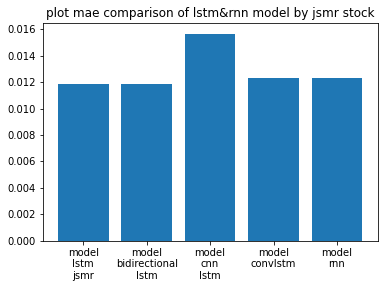

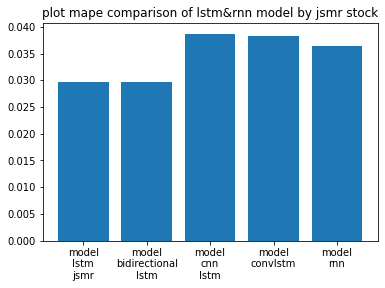

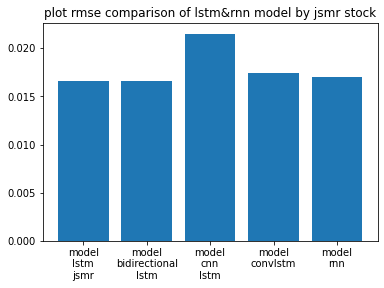

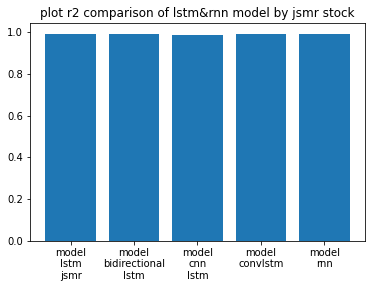

In [ ]:
plot_metriks(mae_jsmr_model,"plot mae comparison of lstm&rnn model by jsmr stock")
plot_metriks(mape_jsmr_model,"plot mape comparison of lstm&rnn model by jsmr stock")
plot_metriks(rmse_jsmr_model,"plot rmse comparison of lstm&rnn model by jsmr stock")
plot_metriks(r2_jsmr_model,"plot r2 comparison of lstm&rnn model by jsmr stock")

# PLOT METRIKS EVALUASI

#### ANTM

In [ ]:
mae_antm_plot = {'mae\nlstm\nantm':mean_absolute_error(preds_antm, y_test_antm),'mae\nbidirectional\nlstm\nantm':mean_absolute_error(preds_antm_bidirectional, y_test_antm),'mae\ncnn\nlstm\nantm':mean_absolute_error(preds_antm_cnn_lstm, y_test_antm_cnn),'mae\nconvlstm\nantm':mean_absolute_error(preds_antm_conv_lstm, y_test_antm_conv),'mae\nrnn\natnm':mean_absolute_error(preds_antm_rnn, y_test_antm_rnn)}

mape_antm_plot = {'mape\nlstm\nantm':mean_absolute_percentage_error(preds_antm, y_test_antm),'mape\nbidirectional\nlstm\nantm':mean_absolute_percentage_error(preds_antm_bidirectional, y_test_antm),'mape\ncnn\nlstm\nantm':mean_absolute_percentage_error(preds_antm_cnn_lstm, y_test_antm_cnn),'mape\nconvlstm\nantm':mean_absolute_percentage_error(preds_antm_conv_lstm, y_test_antm),'mape\nrnn\nantm':mean_absolute_percentage_error(preds_antm_rnn, y_test_antm_rnn)}

rmse_antm_plot = {'rmse\nlstm\nantm':np.sqrt(mean_squared_error(preds_antm, y_test_antm)),'rmse\nbidirectional\nlstm\nantm':np.sqrt(mean_squared_error(preds_antm_bidirectional, y_test_antm)),'rmse\ncnn\nlstm\nantm':np.sqrt(mean_squared_error(preds_antm_cnn_lstm, y_test_antm_cnn)),'convlstm\nantm':np.sqrt(mean_squared_error(preds_antm_conv_lstm, y_test_antm)),'rmse\nrnn\nantm':np.sqrt(mean_squared_error(preds_antm_rnn, y_test_antm_rnn))}

r2_antm_plot = {'r2\nlstm\nantm':r2_score(preds_antm, y_test_antm),'r2\nbidirectional\nlstm\nantm':r2_score(preds_antm_bidirectional, y_test_antm),'r2\ncnn\nlstm\nantm':r2_score(preds_antm_cnn_lstm, y_test_antm_cnn),'r2\nconvlstm\nantm':r2_score(preds_antm_conv_lstm, y_test_antm),'r2\nrnn\nantm':r2_score(preds_antm_rnn, y_test_antm_rnn)} 


In [ ]:
mae_antm = 'Antm Mae'
mape_antm = 'Antm Mape'
rmse_antm = 'Antm Rmse'
r2_antm = 'Antm R2'

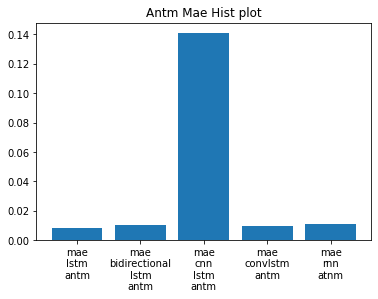

In [ ]:
plot_metriks(mae_antm_plot,mae_antm + " Hist plot")

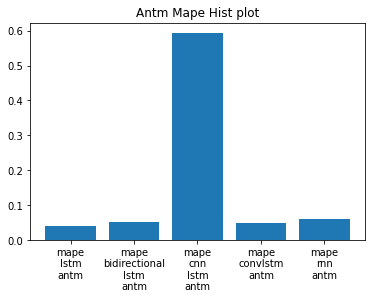

In [ ]:
plot_metriks(mape_antm_plot,mape_antm + " Hist plot")

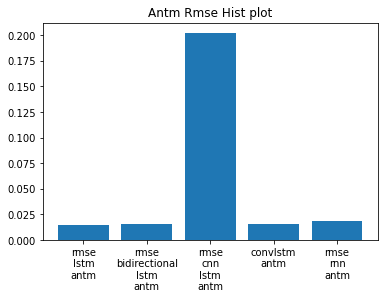

In [ ]:
plot_metriks(rmse_antm_plot,rmse_antm + " Hist plot")

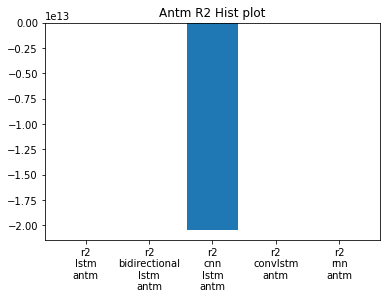

In [ ]:
plot_metriks(r2_antm_plot,r2_antm +" Hist plot")

#### ASII

In [ ]:
mae_asii_plot = {'mae\nlstm\nasii':mean_absolute_error(preds_asii, y_test_asii),'mae\nbidirectional\nlstm\nasii':mean_absolute_error(preds_asii_bidirectional, y_test_asii),'mae\ncnn\nlstm\nasii':mean_absolute_error(preds_asii_cnn_lstm, y_test_asii_cnn),'mae\nconvlstm\nasii':mean_absolute_error(preds_asii_conv_lstm, y_test_asii_conv),'mae\nrnn\natnm':mean_absolute_error(preds_asii_rnn, y_test_asii_rnn)}

mape_asii_plot = {'mape\nlstm\nasii':mean_absolute_percentage_error(preds_asii, y_test_asii),'mape\nbidirectional\nlstm\nasii':mean_absolute_percentage_error(preds_asii_bidirectional, y_test_asii),'mape\ncnn\nlstm\nasii':mean_absolute_percentage_error(preds_asii_cnn_lstm, y_test_asii_cnn),'mape\nconvlstm\nasii':mean_absolute_percentage_error(preds_asii_conv_lstm, y_test_asii),'mape\nrnn\nasii':mean_absolute_percentage_error(preds_asii_rnn, y_test_asii_rnn)}

rmse_asii_plot = {'rmse\nlstm\nasii':np.sqrt(mean_squared_error(preds_asii, y_test_asii)),'rmse\nbidirectional\nlstm\nasii':np.sqrt(mean_squared_error(preds_asii_bidirectional, y_test_asii)),'rmse\ncnn\nlstm\nasii':np.sqrt(mean_squared_error(preds_asii_cnn_lstm, y_test_asii_cnn)),'convlstm\nasii':np.sqrt(mean_squared_error(preds_asii_conv_lstm, y_test_asii)),'rmse\nrnn\nasii':np.sqrt(mean_squared_error(preds_asii_rnn, y_test_asii_rnn))}

r2_asii_plot = {'r2\nlstm\nasii':r2_score(preds_asii, y_test_asii),'r2\nbidirectional\nlstm\nasii':r2_score(preds_asii_bidirectional, y_test_asii),'r2\ncnn\nlstm\nasii':r2_score(preds_asii_cnn_lstm, y_test_asii_cnn),'r2\nconvlstm\nasii':r2_score(preds_asii_conv_lstm, y_test_asii),'r2\nrnn\nasii':r2_score(preds_asii_rnn, y_test_asii_rnn)} 


In [ ]:
mae_asii = 'Asii Mae'
mape_asii = 'Asii Mape'
rmse_asii = 'Asii Rmse'
r2_asii = 'Asii R2'

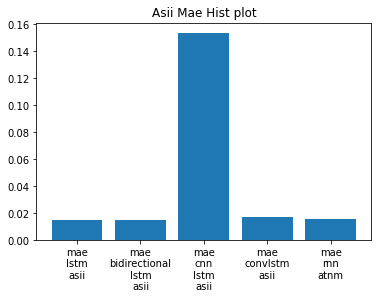

In [ ]:
plot_metriks(mae_asii_plot,mae_asii + " Hist plot")

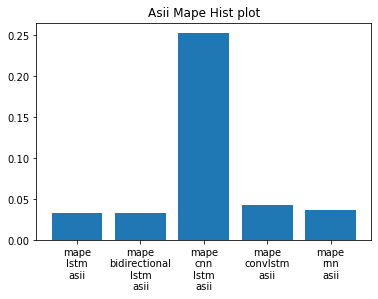

In [ ]:
plot_metriks(mape_asii_plot,mape_asii + " Hist plot")

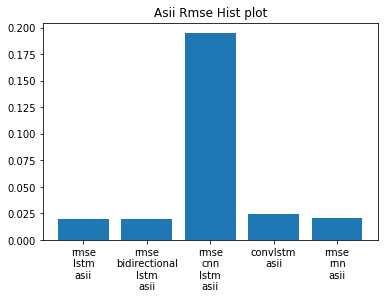

In [ ]:
plot_metriks(rmse_asii_plot,rmse_asii + " Hist plot")

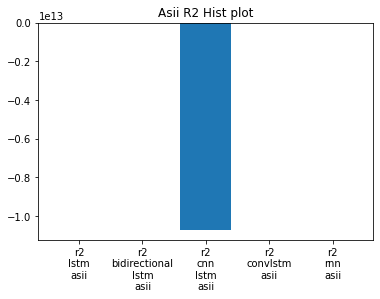

In [ ]:
plot_metriks(r2_asii_plot,r2_asii +" Hist plot")

#### ICBP

In [ ]:
mae_icbp_plot = {'mae\nlstm\nicbp':mean_absolute_error(preds_icbp, y_test_icbp),'mae\nbidirectional\nlstm\nicbp':mean_absolute_error(preds_icbp_bidirectional, y_test_icbp),'mae\ncnn\nlstm\nicbp':mean_absolute_error(preds_icbp_cnn_lstm, y_test_icbp_cnn),'mae\nconvlstm\nicbp':mean_absolute_error(preds_icbp_conv_lstm, y_test_icbp_conv),'mae\nrnn\natnm':mean_absolute_error(preds_icbp_rnn, y_test_icbp_rnn)}

mape_icbp_plot = {'mape\nlstm\nicbp':mean_absolute_percentage_error(preds_icbp, y_test_icbp),'mape\nbidirectional\nlstm\nicbp':mean_absolute_percentage_error(preds_icbp_bidirectional, y_test_icbp),'mape\ncnn\nlstm\nicbp':mean_absolute_percentage_error(preds_icbp_cnn_lstm, y_test_icbp_cnn),'mape\nconvlstm\nicbp':mean_absolute_percentage_error(preds_icbp_conv_lstm, y_test_icbp),'mape\nrnn\nicbp':mean_absolute_percentage_error(preds_icbp_rnn, y_test_icbp_rnn)}

rmse_icbp_plot = {'rmse\nlstm\nicbp':np.sqrt(mean_squared_error(preds_icbp, y_test_icbp)),'rmse\nbidirectional\nlstm\nicbp':np.sqrt(mean_squared_error(preds_icbp_bidirectional, y_test_icbp)),'rmse\ncnn\nlstm\nicbp':np.sqrt(mean_squared_error(preds_icbp_cnn_lstm, y_test_icbp_cnn)),'convlstm\nicbp':np.sqrt(mean_squared_error(preds_icbp_conv_lstm, y_test_icbp)),'rmse\nrnn\nicbp':np.sqrt(mean_squared_error(preds_icbp_rnn, y_test_icbp_rnn))}

r2_icbp_plot = {'r2\nlstm\nicbp':r2_score(preds_icbp, y_test_icbp),'r2\nbidirectional\nlstm\nicbp':r2_score(preds_icbp_bidirectional, y_test_icbp),'r2\ncnn\nlstm\nicbp':r2_score(preds_icbp_cnn_lstm, y_test_icbp_cnn),'r2\nconvlstm\nicbp':r2_score(preds_icbp_conv_lstm, y_test_icbp),'r2\nrnn\nicbp':r2_score(preds_icbp_rnn, y_test_icbp_rnn)} 


In [ ]:
mae_icbp = 'Icbp Mae'
mape_icbp = 'Icbp Mape'
rmse_icbp = 'Icbp Rmse'
r2_icbp = 'Icbp R2'

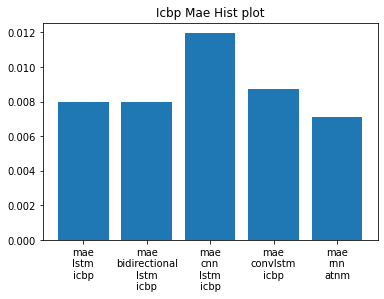

In [ ]:
plot_metriks(mae_icbp_plot,mae_icbp + " Hist plot")

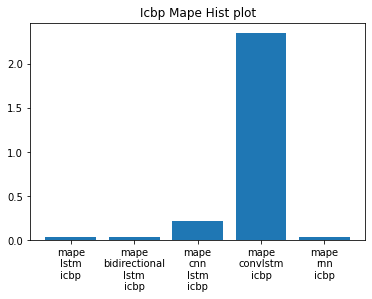

In [ ]:
plot_metriks(mape_icbp_plot,mape_icbp + " Hist plot")

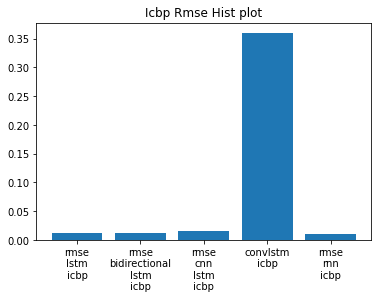

In [ ]:
plot_metriks(rmse_icbp_plot,rmse_icbp + " Hist plot")

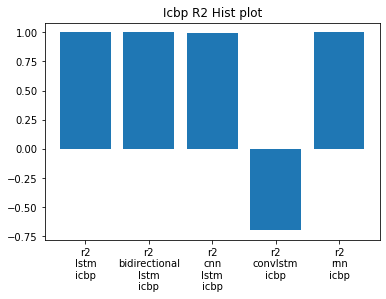

In [ ]:
plot_metriks(r2_icbp_plot,r2_icbp +" Hist plot")

#### JSMR

In [ ]:
mae_jsmr_plot = {'mae\nlstm\njsmr':mean_absolute_error(preds_jsmr, y_test_jsmr),'mae\nbidirectional\nlstm\njsmr':mean_absolute_error(preds_jsmr_bidirectional, y_test_jsmr),'mae\ncnn\nlstm\njsmr':mean_absolute_error(preds_jsmr_cnn_lstm, y_test_jsmr_cnn),'mae\nconvlstm\njsmr':mean_absolute_error(preds_jsmr_conv_lstm, y_test_jsmr_conv),'mae\nrnn\natnm':mean_absolute_error(preds_jsmr_rnn, y_test_jsmr_rnn)}

mape_jsmr_plot = {'mape\nlstm\njsmr':mean_absolute_percentage_error(preds_jsmr, y_test_jsmr),'mape\nbidirectional\nlstm\njsmr':mean_absolute_percentage_error(preds_jsmr_bidirectional, y_test_jsmr),'mape\ncnn\nlstm\njsmr':mean_absolute_percentage_error(preds_jsmr_cnn_lstm, y_test_jsmr_cnn),'mape\nconvlstm\njsmr':mean_absolute_percentage_error(preds_jsmr_conv_lstm, y_test_jsmr_conv),'mape\nrnn\njsmr':mean_absolute_percentage_error(preds_jsmr_rnn, y_test_jsmr_rnn)}

rmse_jsmr_plot = {'rmse\nlstm\njsmr':np.sqrt(mean_squared_error(preds_jsmr, y_test_jsmr)),'rmse\nbidirectional\nlstm\njsmr':np.sqrt(mean_squared_error(preds_jsmr_bidirectional, y_test_jsmr)),'rmse\ncnn\nlstm\njsmr':np.sqrt(mean_squared_error(preds_jsmr_cnn_lstm, y_test_jsmr_cnn)),'convlstm\njsmr':np.sqrt(mean_squared_error(preds_jsmr_conv_lstm, y_test_jsmr_conv)),'rmse\nrnn\njsmr':np.sqrt(mean_squared_error(preds_jsmr_rnn, y_test_jsmr_rnn))}

r2_jsmr_plot = {'r2\nlstm\njsmr':r2_score(preds_jsmr, y_test_jsmr),'r2\nbidirectional\nlstm\njsmr':r2_score(preds_jsmr_bidirectional, y_test_jsmr),'r2\ncnn\nlstm\njsmr':r2_score(preds_jsmr_cnn_lstm, y_test_jsmr_cnn),'r2\nconvlstm\njsmr':r2_score(preds_jsmr_conv_lstm, y_test_jsmr_conv),'r2\nrnn\njsmr':r2_score(preds_jsmr_rnn, y_test_jsmr_rnn)} 


In [ ]:
mae_jsmr = 'Jsmr Mae'
mape_jsmr = 'Jsmr Mape'
rmse_jsmr = 'Jsmr Rmse'
r2_jsmr = 'Jsmr R2'

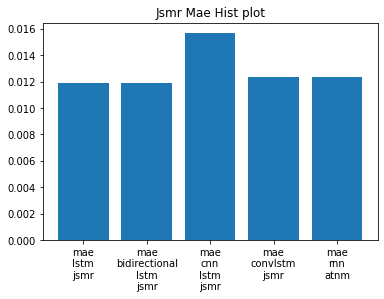

In [ ]:
plot_metriks(mae_jsmr_plot,mae_jsmr + " Hist plot")

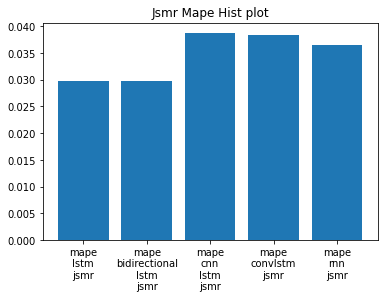

In [ ]:
plot_metriks(mape_jsmr_plot,mape_jsmr + " Hist plot")

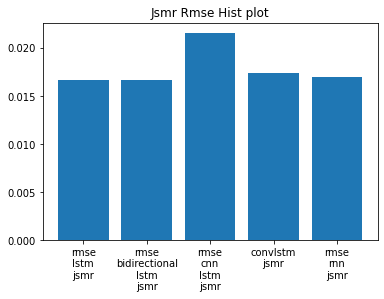

In [ ]:
plot_metriks(rmse_jsmr_plot,rmse_jsmr + " Hist plot")

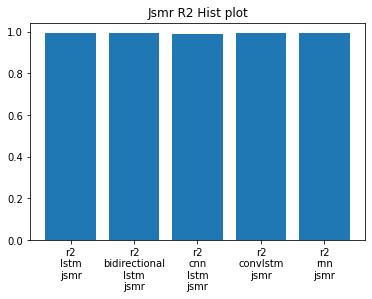

In [ ]:
plot_metriks(r2_jsmr_plot,r2_jsmr +" Hist plot")